In [1]:
import os
import struct

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from IPython.display import HTML

import nibabel as nib

import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('talk')

import cv2
from Pyron.utils.image import Image
from Pyron.utils.niftireader import Nifti

from skimage.metrics import peak_signal_noise_ratio as PSNR
from skimage.metrics import structural_similarity as SSIM

N_SLIDES  = 176
N_WEIGHTS = 2
N_CASES   = 10
N_ANGLES  = 20

TOT_FILE  = N_SLIDES * N_WEIGHTS * N_CASES * N_ANGLES

chan_dict = {0 : 'R',
            1 : 'G',
            2 : 'B',
}

def shift(img, ox, oy):
  
  non = lambda s: s if s<0 else None
  mom = lambda s: max(0,s)

  shifted = np.zeros_like(img) + img[0,0]
  shifted[mom(oy):non(oy), mom(ox):non(ox)] = img[mom(-oy):non(-oy), mom(-ox):non(-ox)]

  return shifted
  
def load_dataset():

  filename = os.path.join('~', 'data_NAMIC', 'psnr_ssim_rotate_orig.csv')

  df = pd.read_csv(filename)

  assert len(df) == TOT_FILE

  weights = df['weight'].unique()
  scales  = df['scale'].unique()

  dataframe_list = []
  for w in weights:
    for s in scales:
      w_cond = df['weight'] == w
      s_cond = df['scale'] == s

      dataframe_list.append(df[w_cond & s_cond])

  # order : [t2, 2] [t2, 4] [t1, 2] [t1, 4]
  return [d.reset_index(drop=True) for d in dataframe_list]

def build_filename(case, weight, scale, angle, channel):
  
  root = os.path.join(os.path.expanduser('~'), 'data_NAMIC')
  orig = os.path.join(root, 'orig', weight, f'{case}_{weight}.nii') 

  sr = os.path.join(root, 'nifti_sr', f'{case}_{weight}_{scale}lr_bc_gauss_sr_{angle:03}_{chan_dict[channel]}.nii')
  bc = os.path.join(root, 'nifti_bc', f'{case}_{weight}_{scale}lr_bc_gauss_bc_{angle:03}.nii')

  return orig, sr, bc

def load_bin(filename, dtype):

  with open(filename, 'rb') as f:

    h, w, c = struct.unpack('iii', f.read(12))
    out = np.fromfile(f, dtype=dtype, offset=0).reshape(h, w, c)
  
  return out

def rescale(im):
  return (im - im.min()) * (1. / (im.max() - im.min()))
    
def rescale_by_channel(im):

  M = im.max(axis=(0, 1))
  m = im.min(axis=(0, 1))

  return (im - m) * (1. / (M - m))

def load_images(case, weight, scale, angle, channel):
  
  origName, srName, bcName = build_filename(case, weight, scale, angle, channel)

  # Loading with Nibabel
  orig = nib.load(origName).get_fdata()
  orig = rescale(orig).transpose(2, 0, 1)
  
  bc = nib.load(bcName).get_fdata().transpose(2, 0, 1)
  bc = rescale(bc)
  
  sr = nib.load(srName).get_fdata().transpose(2, 0, 1)
  sr = rescale(sr)
  
  return orig, sr, bc

def to_orientation(sr_image, bc_image, angle, scale):
  
  h, w = sr_image.shape
  
  sr_rot = Image.from_numpy_matrix(sr_image.reshape(h, w, 1)).rotate(-angle-90).flip(axis=0).data
  bc_rot = Image.from_numpy_matrix(bc_image.reshape(h, w, 1)).rotate(-angle-90).flip(axis=0).data
  
  sr_rot = shift(sr_rot[:,:,0], oy=scale*4, ox=-1)

  return sr_rot, bc_rot[:,:,0]
  
def name_switch(df):
  
  if df is df_x2_t2:
    return 'model edsrx2 in t2'

  elif df is df_x2_t1:
    return 'model edsrx2 in t1'

  elif df is df_x4_t2:
    return 'model wdsrx4 in t2'

  elif df is df_x4_t1:
    return 'model wdsrx4 in t1'

  else:
    raise ValueError('dt is wrong')


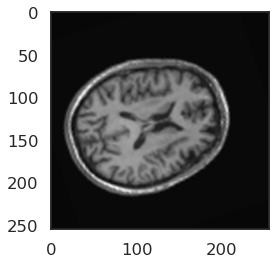

In [195]:
# Test image loading

# correct rotation : 
# rotate(-angle-90).flip(axis=0)

sns.set_style('white')
plt.set_cmap('gray')

case    = 'case01015'
weight  = 't1'
scale   = 2
angle   = 108
channel = 2
 
slide = 100
  
orig, sr, bc = load_images(case, weight, scale, angle, channel)

plt.imshow(bc[slide])

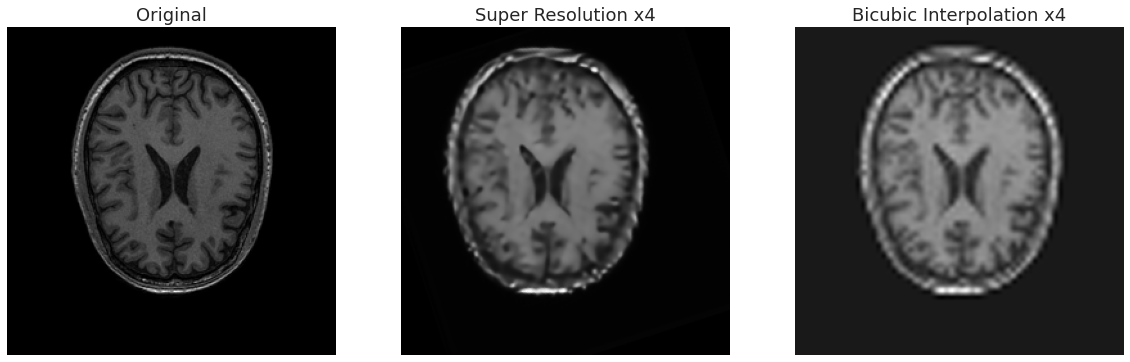

In [177]:
sns.set_style('white')

case   = 'case01015'
weight = 't1'
scale  = 4
slide  = 103
angle  = 18

orig, sr, bc = load_images(case, weight, scale, slide, angle)

filename = os.path.join(os.path.expanduser('~'), 'data_NAMIC', 't1', f'case01015_t1_{scale}lr_bc_gauss.nii')

small = nib.load(filename).get_fdata()[:,:,slide]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))

ax1.imshow(orig, cmap='gray')
ax1.set_title('Original')
ax1.set_axis_off()

ax2.imshow(sr[:,:,0], cmap='gray')
ax2.set_title(f'Super Resolution x{scale}')
ax2.set_axis_off()

ax3.imshow(bc, cmap='gray')
ax3.set_title(f'Bicubic Interpolation x{scale}')
ax3.set_axis_off()

plt.savefig(f'../images/ref_{case}_{weight}_{scale}lr_{slide:03}_{angle:03}')

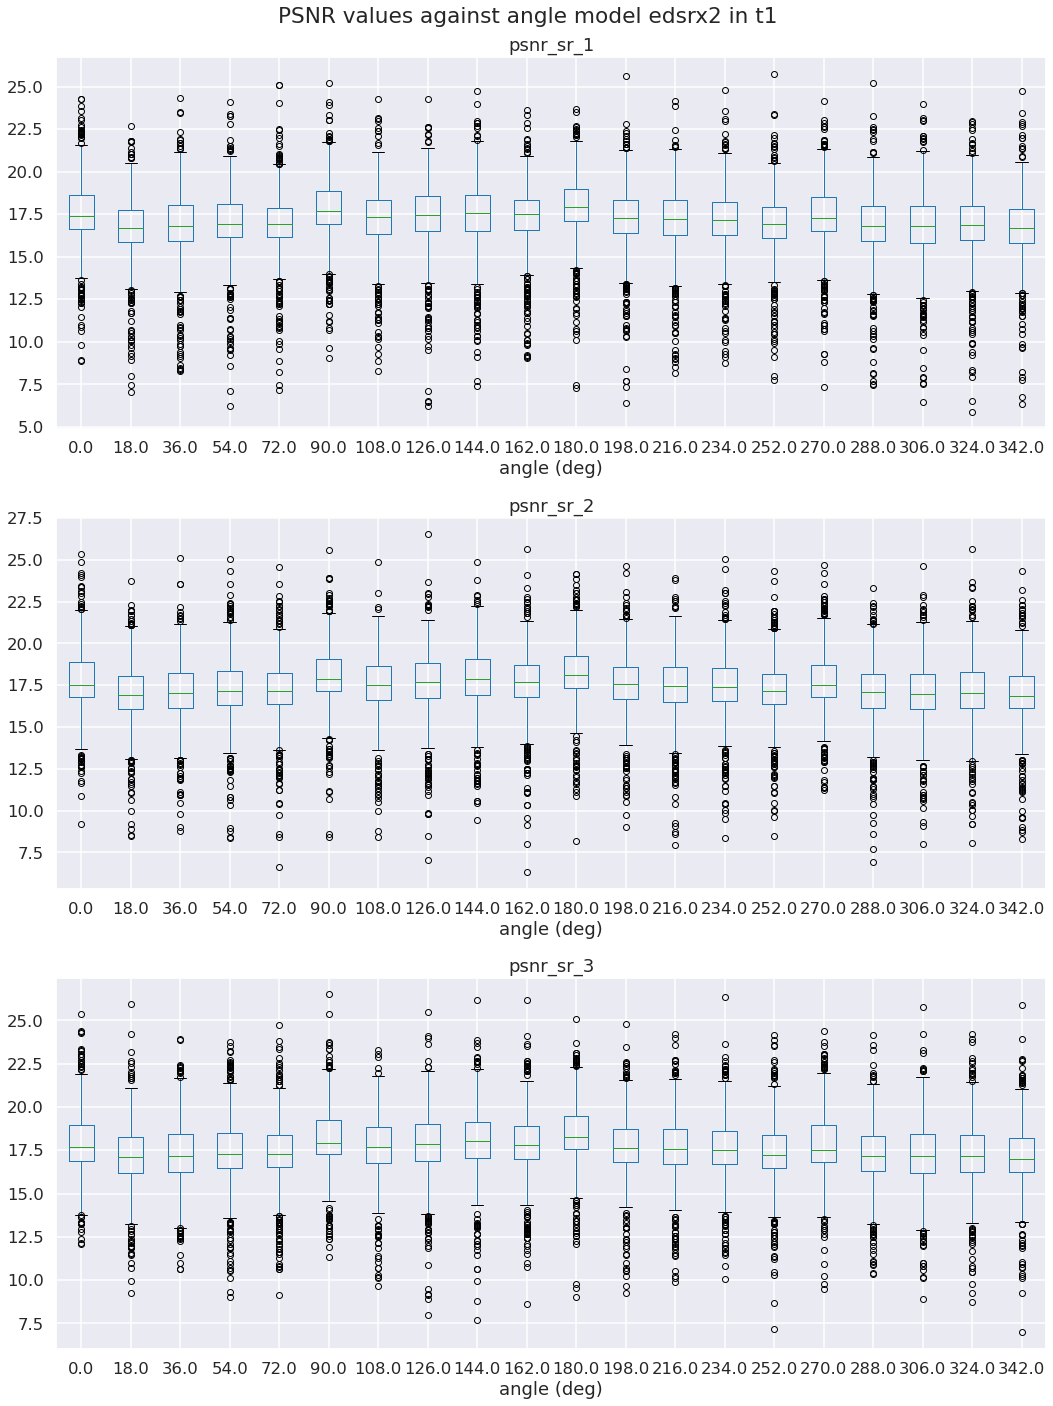

In [107]:
# start from simply x2_t1 for example

dt = df_x2_t1

name = name_switch(dt)

fig, row = plt.subplots(3, 1, figsize=(15, 20))

for i, ax in enumerate(row) :
  dt.boxplot(ax=ax, column='psnr_sr_{}'.format(i+1), by='angle (deg)')

fig.suptitle(f'PSNR values against angle {name}')

plt.tight_layout()
plt.show()

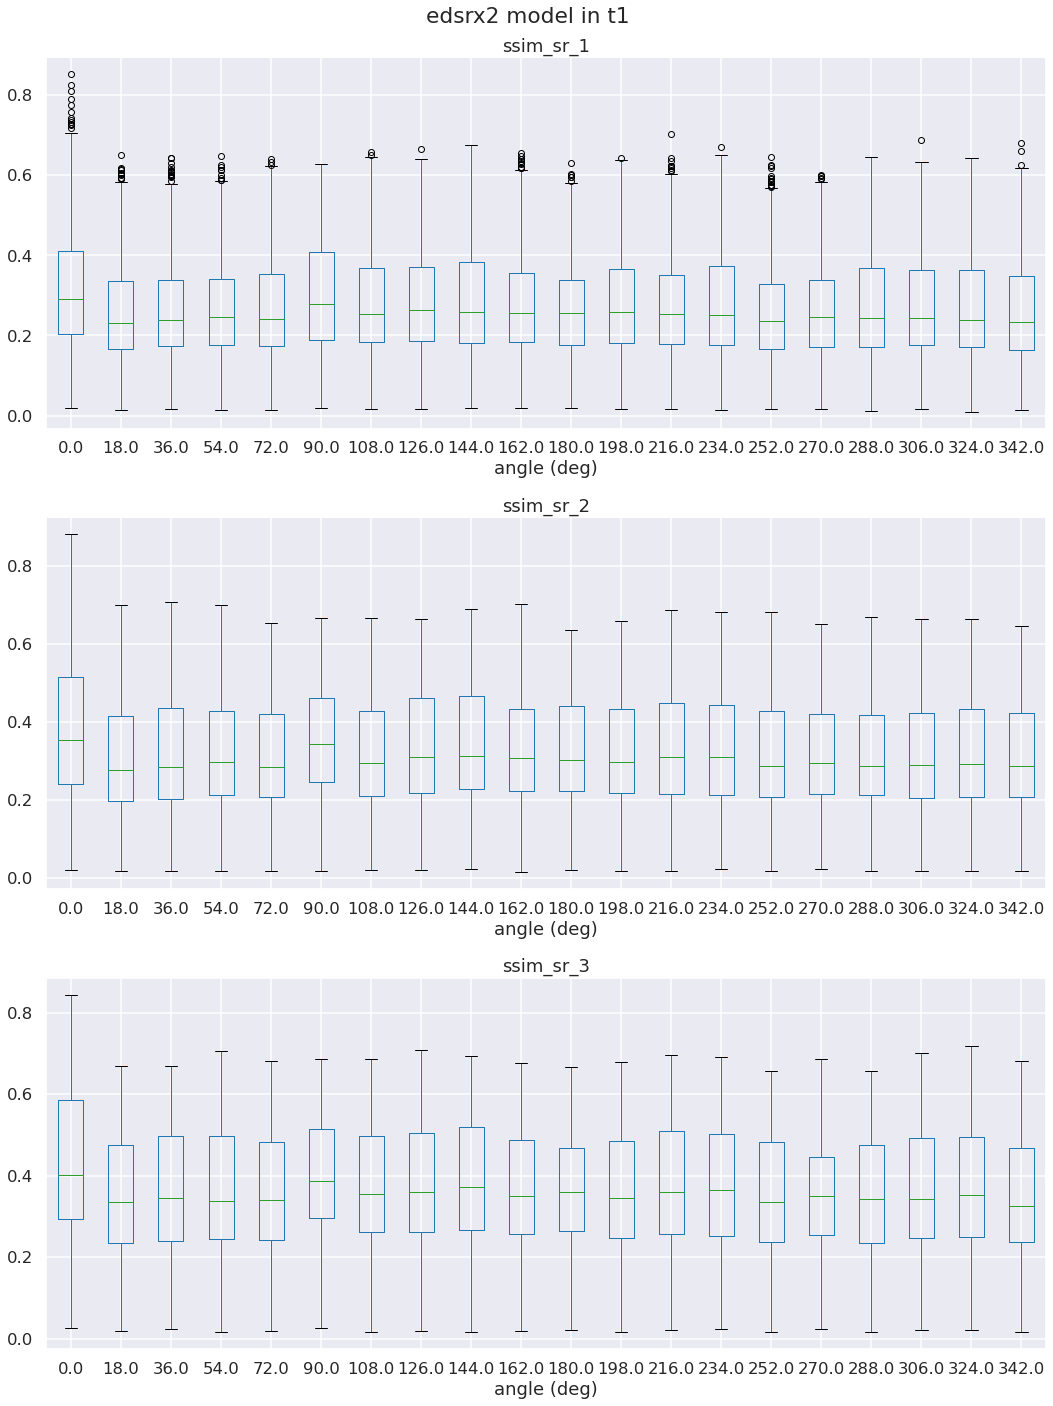

In [58]:
# ssim  boxplotting for edsr and 

dt = df_x2_t1

name = name_switch(dt)

fig, row = plt.subplots(3, 1, figsize=(15, 20))

for i, ax in enumerate(row) :
  dt.boxplot(ax=ax, column='ssim_sr_{}'.format(i+1), by='angle (deg)')

fig.suptitle('edsrx2 model in t1')
  
plt.tight_layout()
plt.show()

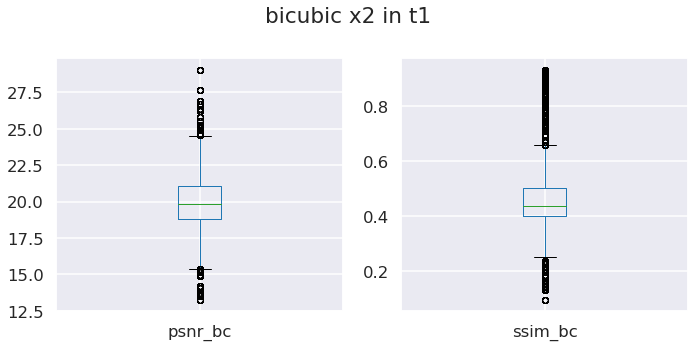

In [115]:
# bc boxplot

dt = df_x2_t1

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 5))

dt.boxplot(ax=ax1, column='psnr_bc')
dt.boxplot(ax=ax2, column='ssim_bc')

fig.suptitle('bicubic x2 in t1')
  
plt.tight_layout()
plt.show()

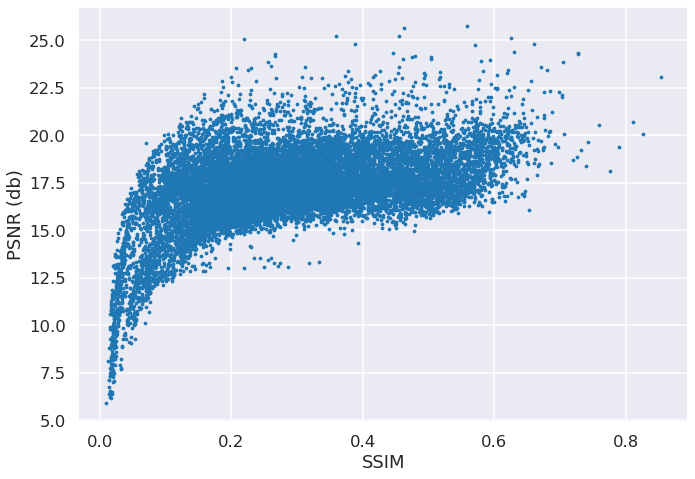

In [35]:
# graph psnr-ssim. The other cases are very different

dt = df_x2_t1
name = name_switch(dt)

fig, ax = plt.subplots(1, 1, figsize=(10, 7))

dt.plot.scatter(ax=ax, x='ssim_sr_1', y='psnr_sr_1', marker='.')
ax.set_xlabel('SSIM')
ax.set_ylabel('PSNR (db)')

plt.tight_layout()
plt.show()

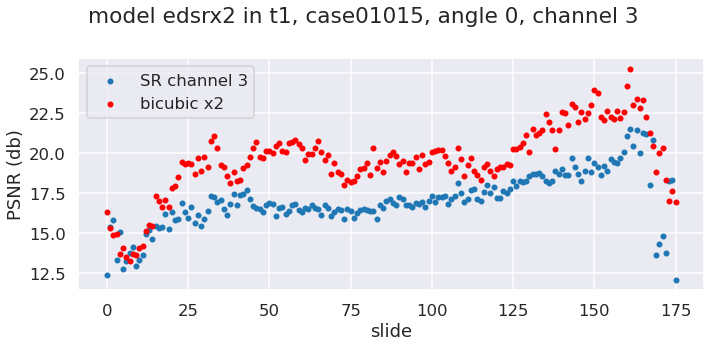

In [33]:
# scatter for value of psnr separated per scale and angle

sns.set_style('darkgrid')

dt = df_x2_t1
name = name_switch(dt)

case = 'case01015'
ang  = 0
chan = 3

angle_cond = dt['angle (deg)'] == ang
case_cond  = dt['case'] == case

dt = dt[angle_cond & case_cond]

fig, ax = plt.subplots(1,1, figsize=(10, 5))
dt.plot.scatter(x='slide', y=f'psnr_sr_{chan}', ax=ax,    label=f'SR channel {chan}')
dt.plot.scatter(x='slide', y='psnr_bc', ax=ax, color='r', label=f'bicubic {name.split(" ")[1].split("r")[1]}')

ax.set_ylabel('PSNR (db)')
ax.legend()

fig.suptitle(f'{name}, {case}, angle {ang}, channel {chan}')
plt.tight_layout()
plt.show()

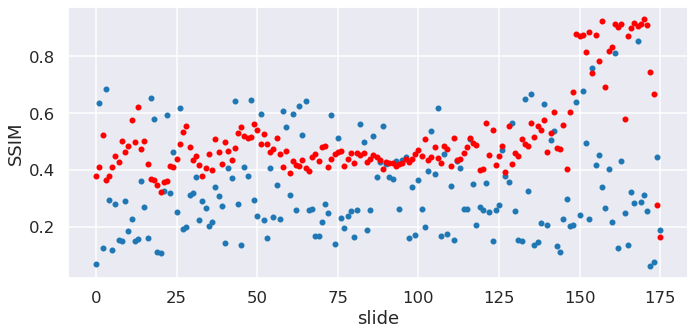

In [24]:
# scatter for value of ssim separated per case and angle

sns.set_style('darkgrid')

dt = df_x2_t1

angle_cond = dt['angle (deg)'] == 0
case_cond  = dt['case'] == 'case01028'

dt = dt[angle_cond & case_cond]

fig, ax = plt.subplots(1,1, figsize=(10, 5))
dt.plot.scatter(x='slide', y='ssim_sr_1', ax=ax)
dt.plot.scatter(x='slide', y='ssim_bc', ax=ax, color='r')

ax.set_ylabel('SSIM')

plt.tight_layout()
plt.show()

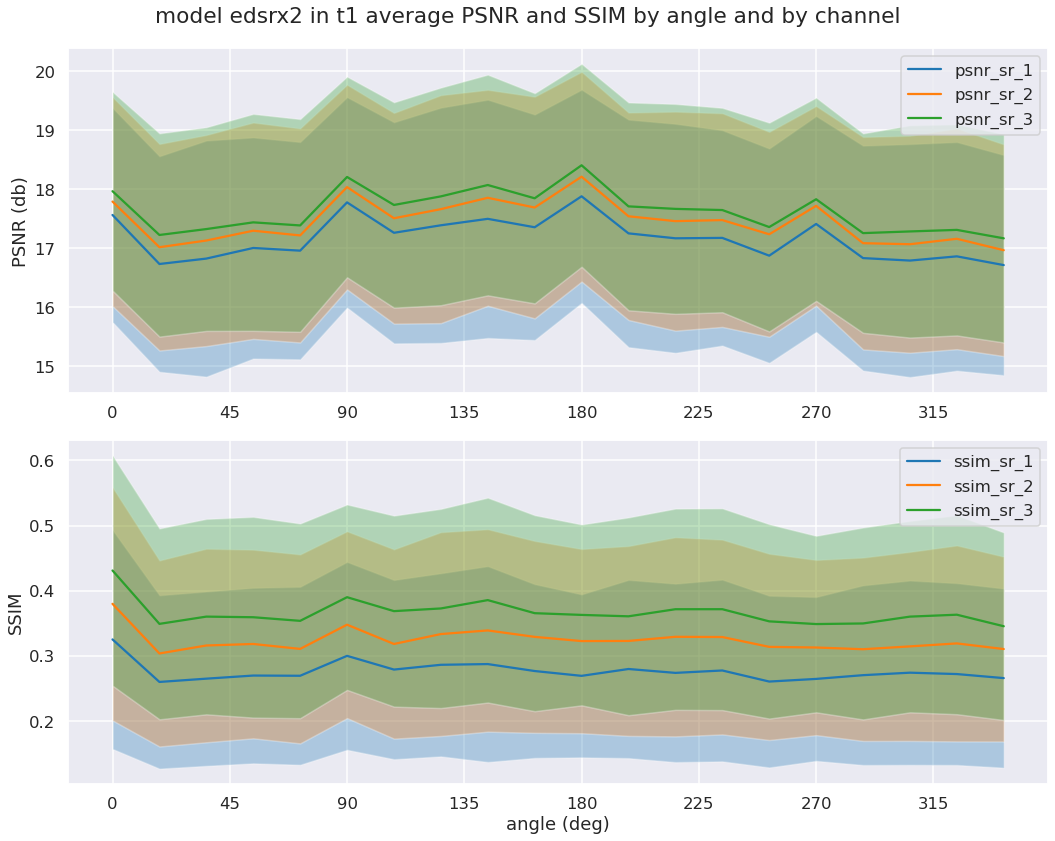

In [26]:
# plot of mean psnr and ssim as function of angle

dt = df_x2_t1
name = name_switch(dt)

byangle = dt.groupby('angle (deg)')

avg = byangle.mean()
std = byangle.std() 

x = np.arange(0, 360, 18)
x_tick = np.arange(0, 360, 45)

min_val = avg - std 
max_val = avg + std

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

for i in range(3):
  lab = f'psnr_sr_{i+1}'
  ax1.plot(x, avg[lab], label=lab)
  ax1.fill_between(x=x, y1=max_val[lab], y2=min_val[lab], alpha=0.3)
  
ax1.legend()
ax1.set_ylabel('PSNR (db)')
ax1.set_xticks(x_tick)

for i in range(3):
  lab = f'ssim_sr_{i+1}'
  ax2.plot(x, avg[lab], label=lab)
  ax2.fill_between(x=x, y1=max_val[lab], y2=min_val[lab], alpha=0.3)

ax2.set_xlabel('angle (deg)')
ax2.set_ylabel('SSIM')
ax2.set_xticks(x_tick)
ax2.legend()

fig.suptitle(name + ' average PSNR and SSIM by angle and by channel')
plt.tight_layout()
plt.show()

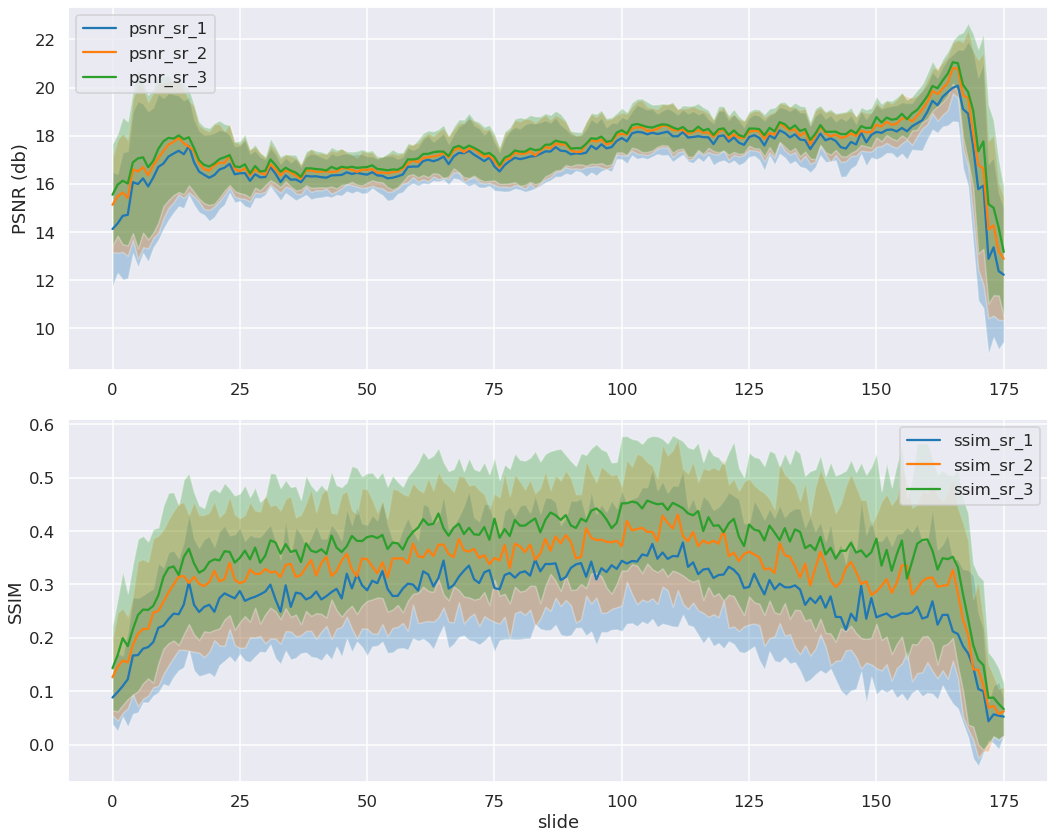

In [79]:
# same as above for angles

dt = df_x2_t1
name = name_switch(dt)

byangle = dt.groupby('slide')

avg = byangle.mean()
std = byangle.std() 

x = np.arange(0, 176, 1)

min_val = avg - std 
max_val = avg + std

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

for i in range(3):
  lab = f'psnr_sr_{i+1}'
  ax1.plot(x, avg[lab], label=lab)
  ax1.fill_between(x=x, y1=max_val[lab], y2=min_val[lab], alpha=0.3)
  
ax1.legend()
ax1.set_ylabel('PSNR (db)')

for i in range(3):
  lab = f'ssim_sr_{i+1}'
  ax2.plot(x, avg[lab], label=lab)
  ax2.fill_between(x=x, y1=max_val[lab], y2=min_val[lab], alpha=0.3)

ax2.set_xlabel('slide')
ax2.set_ylabel('SSIM')
ax2.legend()

plt.tight_layout()
plt.show()

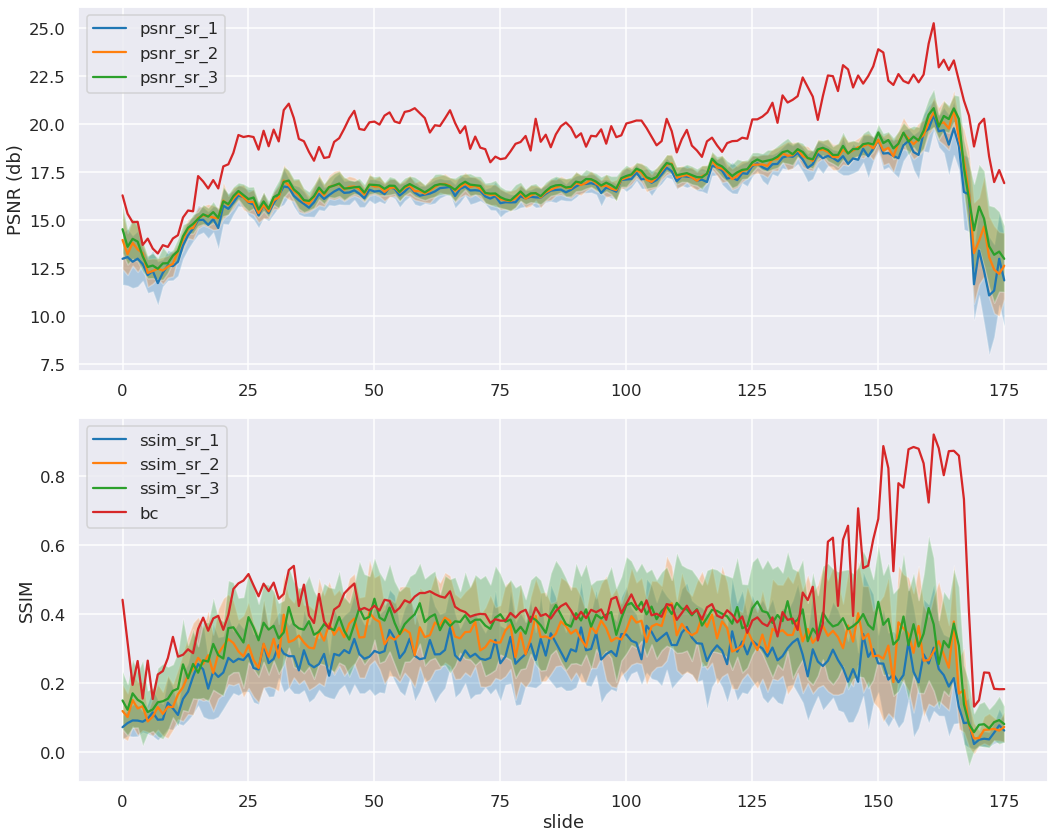

In [52]:
# analysis on case01015, image available for t1 for bc, srx2 and srx4

dt = df_x2_t1
name = name_switch(dt)
case = 'case01015'

dt = dt[dt['case'] == case]

## Boxplot essentially the same

## Plot grouped by slide
byangle = dt.groupby('slide')

avg = byangle.mean()
std = byangle.std() 

x = np.arange(0, 176, 1)

min_val = avg - std 
max_val = avg + std

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

for i in range(3):
  lab = f'psnr_sr_{i+1}'
  ax1.plot(x, avg[lab], label=lab)
  ax1.fill_between(x=x, y1=max_val[lab], y2=min_val[lab], alpha=0.3)
  
ax1.legend()
ax1.set_ylabel('PSNR (db)')

ax1.plot(x, avg['psnr_bc'], label='bc')

for i in range(3):
  lab = f'ssim_sr_{i+1}'
  ax2.plot(x, avg[lab], label=lab)
  ax2.fill_between(x=x, y1=max_val[lab], y2=min_val[lab], alpha=0.3)

ax2.plot(x, avg['ssim_bc'], label='bc')
ax2.set_xlabel('slide')
ax2.set_ylabel('SSIM')
ax2.legend()

plt.tight_layout()
plt.show()


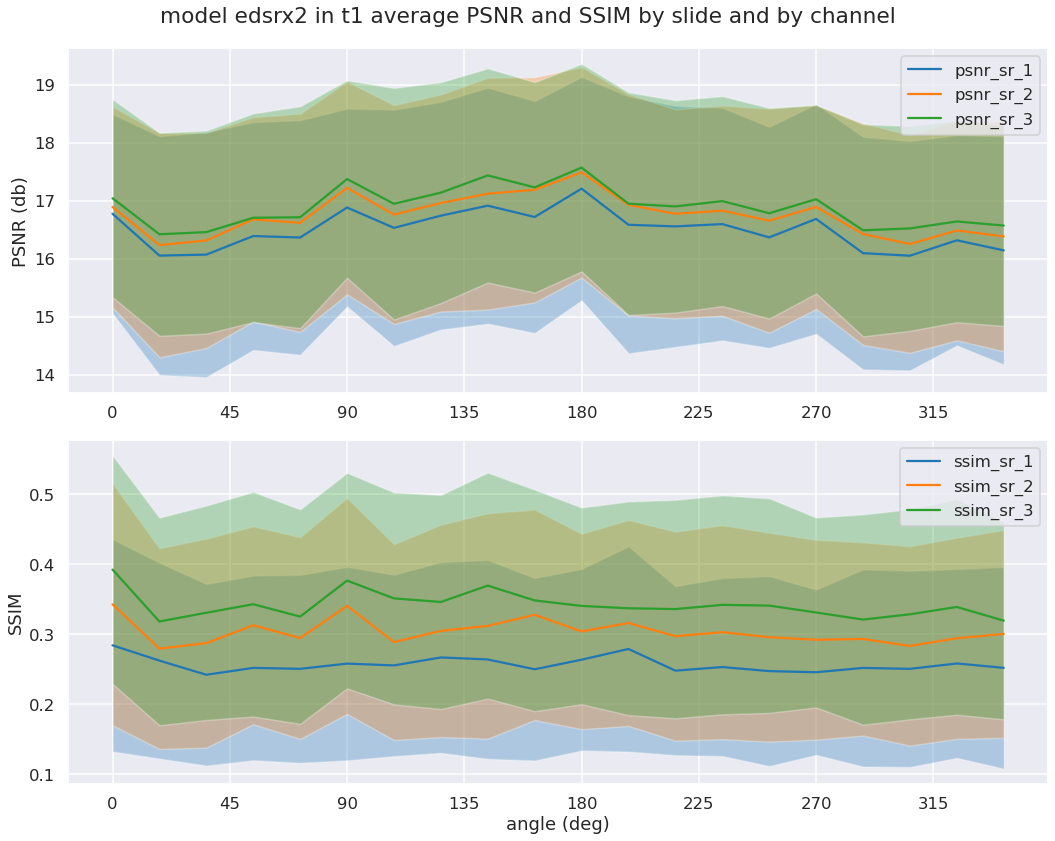

In [110]:
# same as above with 

dt = df_x2_t1
name = name_switch(dt)
case = 'case01015'

dt = dt[dt['case'] == case]

byangle = dt.groupby('angle (deg)')

avg = byangle.mean()
std = byangle.std() 

x = np.arange(0, 360, 18)
x_tick = np.arange(0, 360, 45)

min_val = avg - std 
max_val = avg + std

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

for i in range(3):
  lab = f'psnr_sr_{i+1}'
  ax1.plot(x, avg[lab], label=lab)
  ax1.fill_between(x=x, y1=max_val[lab], y2=min_val[lab], alpha=0.3)
  
ax1.legend()
ax1.set_ylabel('PSNR (db)')
ax1.set_xticks(x_tick)

for i in range(3):
  lab = f'ssim_sr_{i+1}'
  ax2.plot(x, avg[lab], label=lab)
  ax2.fill_between(x=x, y1=max_val[lab], y2=min_val[lab], alpha=0.3)

ax2.set_xlabel('angle (deg)')
ax2.set_ylabel('SSIM')
ax2.set_xticks(x_tick)
ax2.legend()

fig.suptitle(name + ' average PSNR and SSIM by slide and by channel')
plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

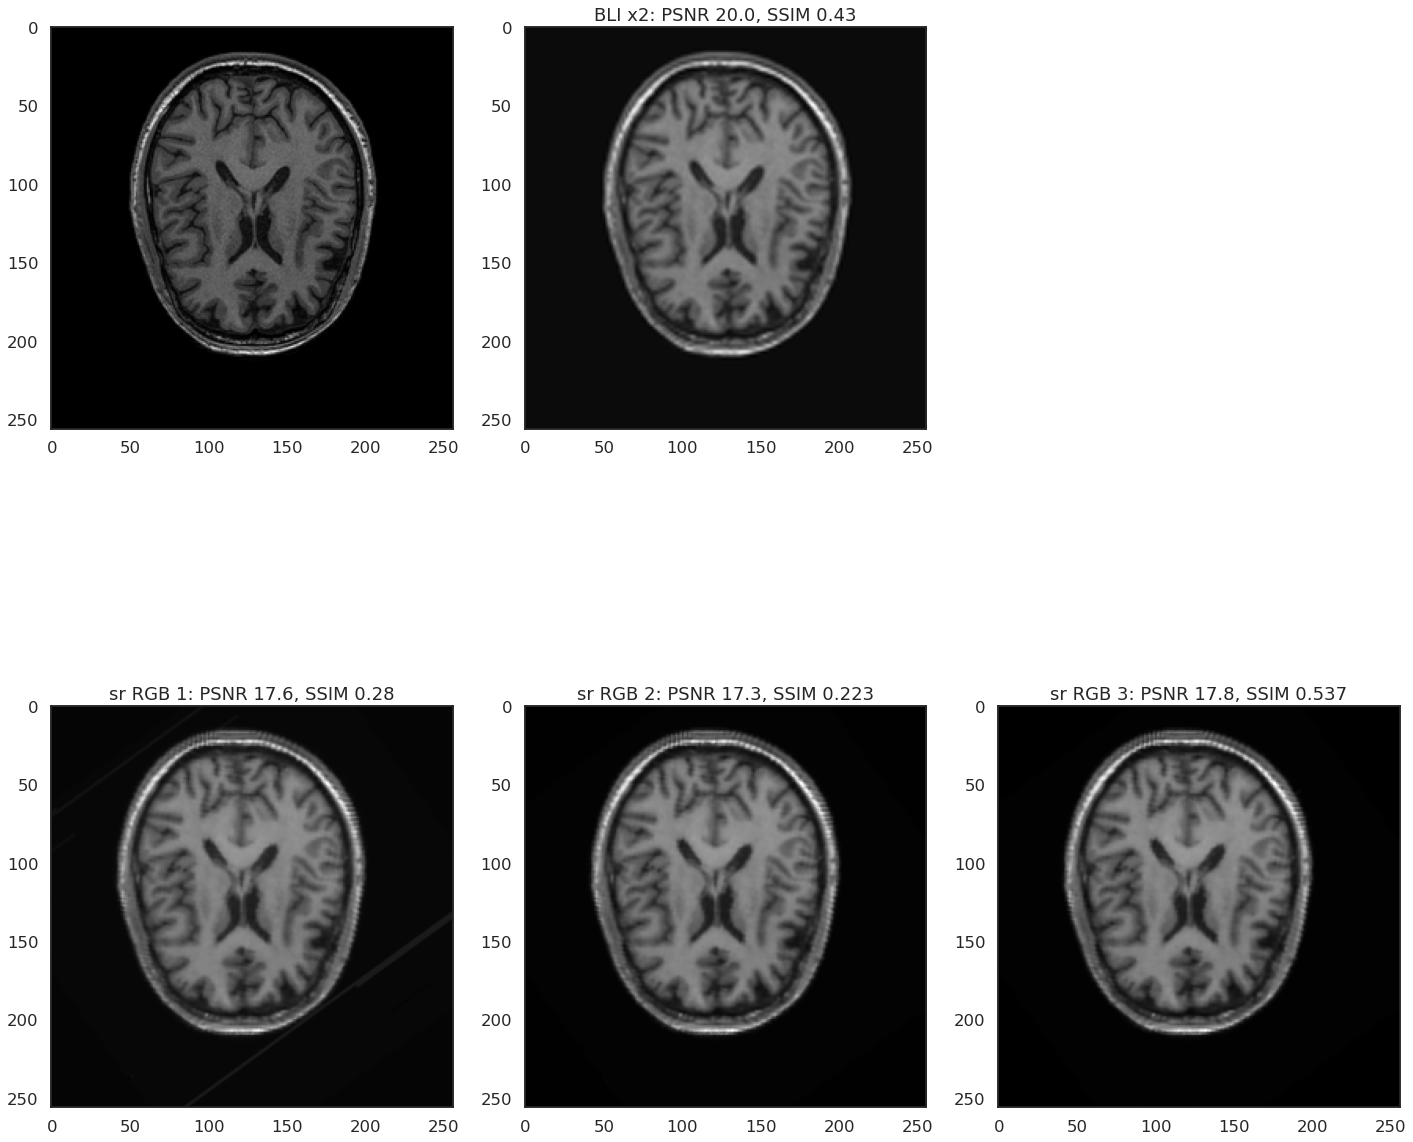

0.5223949523116449 19.953080242477537
0.7717214925584239 20.165534520990605
0.838108568810982 20.29820523515676


In [219]:
# show some images for case01015, the range is approximately from 0 to 170

sns.set_style('white')
sns.set_context('talk')
plt.set_cmap('gray')

dt = df_x2_t1

# only images downloaded
case   = 'case01015'
weight = 't1'

angle  = 0
slide  = 100
angle  = 36
scale  = 2

case_mask  = dt['case']  == case
angle_mask = dt['angle (deg)'] == angle
slide_mask = dt['slide'] == slide

dt = dt[case_mask & angle_mask & slide_mask]

orig, sr, bc = load_images(case, weight, scale, slide, angle)

# Plotting 
fig, (row1, row2) = plt.subplots(2, 3, figsize=(20, 20))

ax1, ax2, ax6 = row1

ax1.imshow(orig)
ax2.imshow(bc)
ssim = dt['ssim_bc'].values[0]
psnr = dt['psnr_bc'].values[0]
ax2.set_title(f'BLI x{scale}: PSNR {psnr:.3}, SSIM {ssim:.3}')

for i, ax in enumerate(row2):
  ssim = dt[f'ssim_sr_{i+1}'].values[0]
  psnr = dt[f'psnr_sr_{i+1}'].values[0]
  ax.imshow(sr[:,:,i])
  ax.set_title(f'sr RGB {i+1}: PSNR {psnr:.3}, SSIM {ssim:.3}')

ax6.remove()
plt.tight_layout()
plt.show();

for i in range(3):
  print(SSIM(orig, shift(sr[:,:,i], ox=scale*4, oy=0)), PSNR(orig, shift(sr[:,:,i], ox=scale*4, oy=0)))

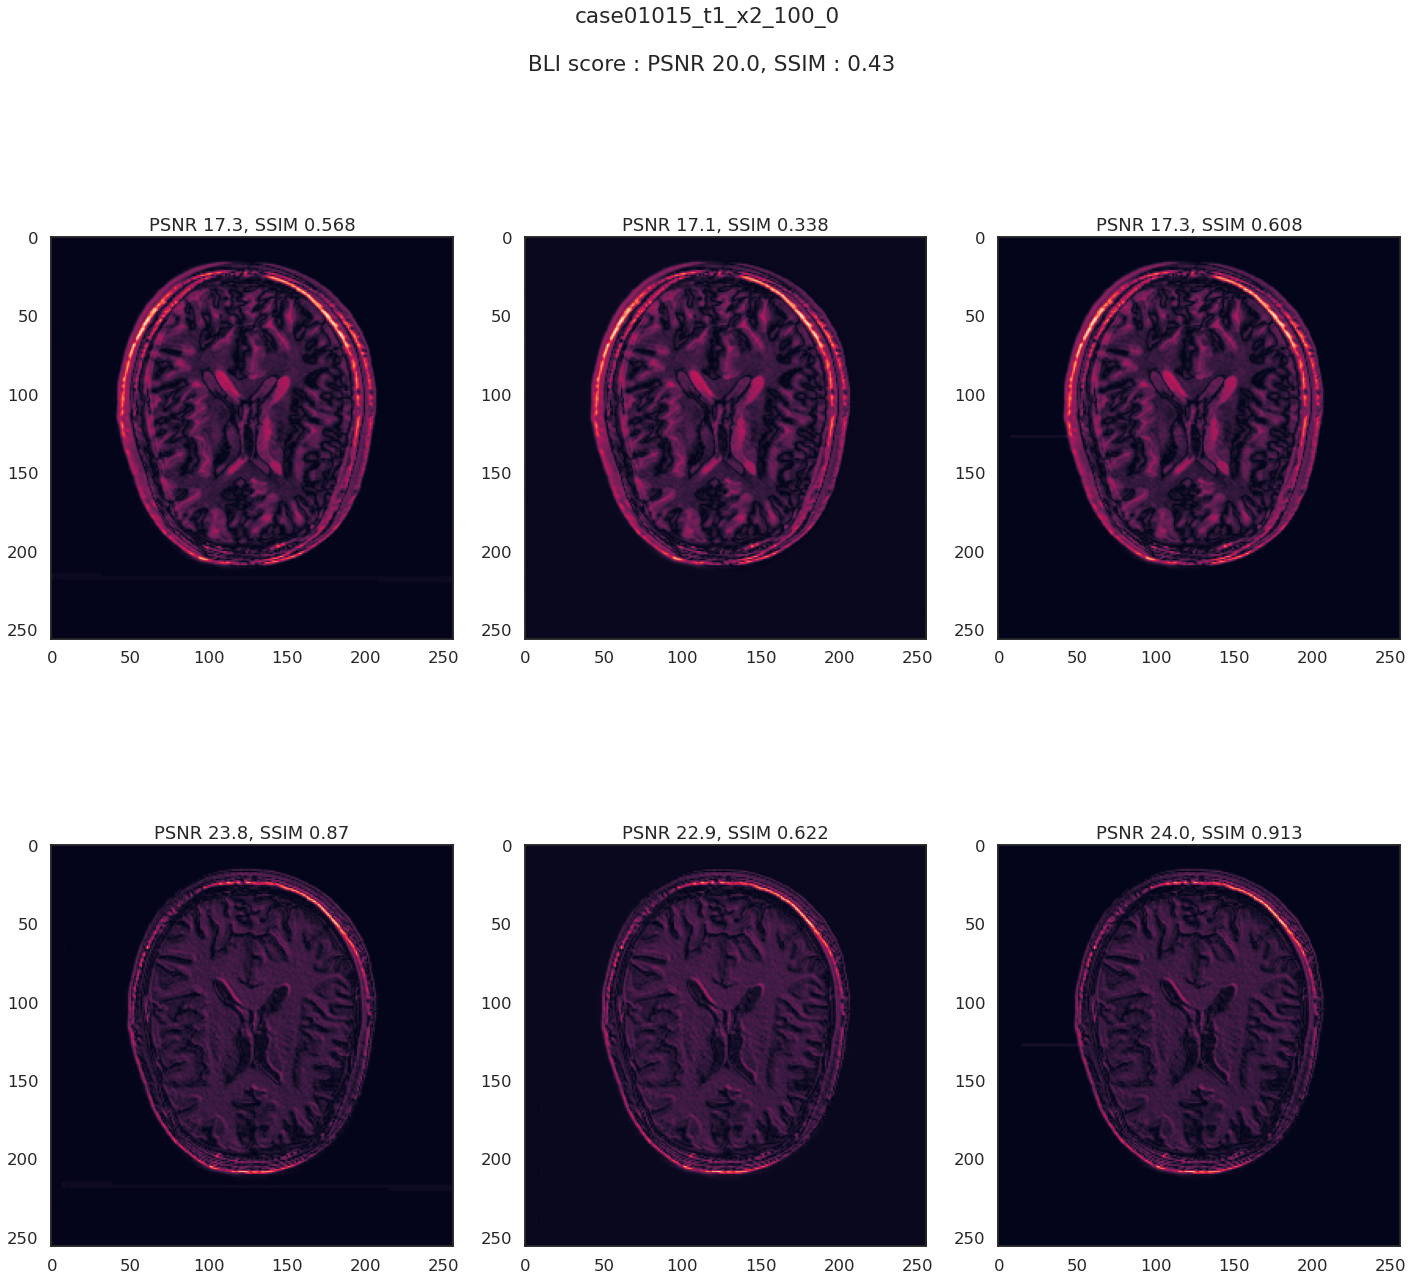

In [124]:
# absolute diff by channel orig - sr 

sns.set_style('white')
sns.set_context('talk')
# plt.set_cmap('')

# only images downloaded
case   = 'case01015'
weight = 't1'

angle  = 0
slide  = 100
angle  = 0
scale  = 2

if scale == 2:
  dt = df_x2_t1
elif scale == 4:
  dt = df_x4_t1

case_mask  = dt['case']  == case
angle_mask = dt['angle (deg)'] == angle
slide_mask = dt['slide'] == slide

dt = dt[case_mask & angle_mask & slide_mask]

orig, sr, bc = load_images(case, weight, scale, slide, angle)

# Plotting 
fig, (row1, row2) = plt.subplots(2, 3, figsize=(20, 20))

bc_psnr = PSNR(orig, bc)
bc_ssim = SSIM(orig, bc)

PSRNs = [PSNR(orig, sr[:,:,i]) for i in range(3)]
SSIMs = [SSIM(orig, sr[:,:,i]) for i in range(3)]

for i, ax in enumerate(row1):
  psnr = PSRNs[i]
  ssim = SSIMs[i]
  ax.imshow(np.abs(orig - sr[:,:,i]))
  ax.set_title(f'PSNR {psnr:.3}, SSIM {ssim:.3}')

PSRNs = [PSNR(orig, shift(sr[:,:,i], ox=scale*4, oy=0)) for i in range(3)]
SSIMs = [SSIM(orig, shift(sr[:,:,i], ox=scale*4, oy=0)) for i in range(3)]
  
for i, ax in enumerate(row2):
  psnr = PSRNs[i]
  ssim = SSIMs[i]
  ax.imshow(np.abs(orig - shift(sr[:,:,i], ox=scale*4-1, oy=1)))
  ax.set_title(f'PSNR {psnr:.3}, SSIM {ssim:.3}')
  
title = f'{case}_{weight}_x{scale}_{slide}_{angle}'
fig.suptitle(title + f'\n\n BLI score : PSNR {bc_psnr:.3}, SSIM : {bc_ssim:.3}')
plt.tight_layout();
# plt.savefig('../images/' + title)

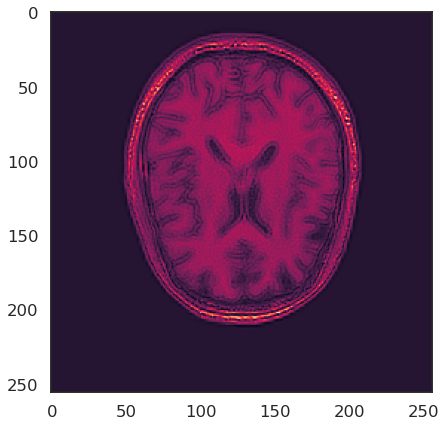

In [206]:
# absolute diff by channel orig - bc

sns.set_style('white')
sns.set_context('talk')
# plt.set_cmap('')

dt = df_x2_t1

# only images downloaded
case   = 'case01015'
weight = 't1'

angle  = 0
slide  = 100
angle  = 0
scale  = 2

if scale == 2:
  dt = df_x2_t1
elif scale == 4:
  dt = df_x4_t1

case_mask  = dt['case']  == case
angle_mask = dt['angle (deg)'] == angle
slide_mask = dt['slide'] == slide

dt = dt[case_mask & angle_mask & slide_mask]

orig, _, bc = load_images(case, weight, scale, slide, angle)

# Plotting 
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

ax.imshow(np.abs(orig - bc))

plt.show();

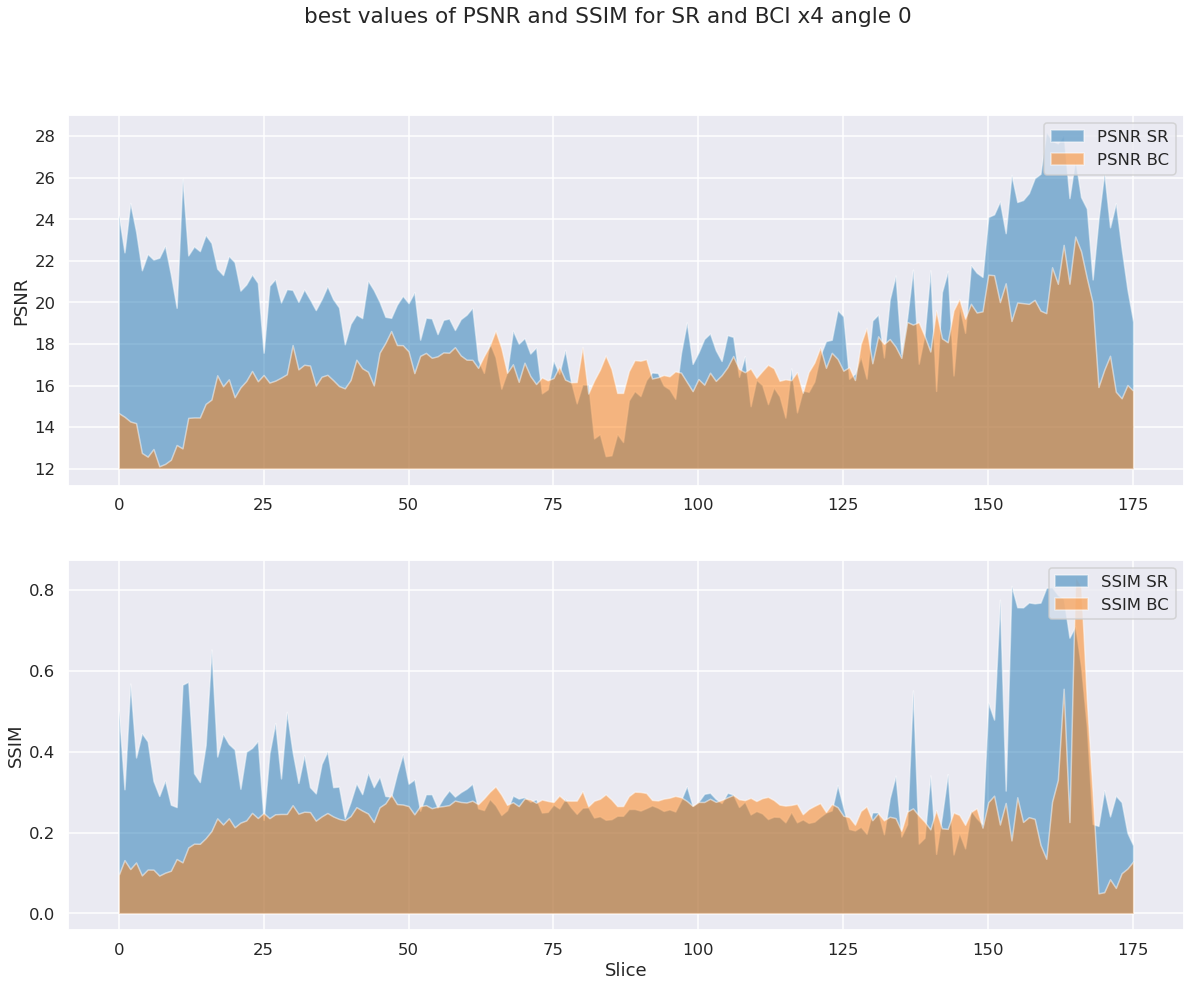

In [204]:
sns.set_style('darkgrid')
sns.set_context('talk')

shift_df = pd.read_csv('psnr_ssim_shift.csv')

case   = 'case01015'
weight = 't1'

angle = 0
scale = 4
# slide = 100

angle_mask = shift_df['angle (deg)'] == angle
scale_mask = shift_df['scale'] == scale

shift_df = shift_df[angle_mask & scale_mask]

psnr_best_values = []
ssim_best_values = []
for i in range(176):
  
  slide_mask = shift_df['slide'] == i 
  
  best_psnr = shift_df[slide_mask][[f'psnr_sr_{i+1}' for i in range(3)]].values.max()
  best_ssim = shift_df[slide_mask][[f'ssim_sr_{i+1}' for i in range(3)]].values.max()

  psnr_best_values.append(best_psnr)
  ssim_best_values.append(best_ssim)
    
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,15))

# ax1.plot(shift_df['slide'], psnr_best_values, label='PSNR SR')
ax1.fill_between(shift_df['slide'], psnr_best_values, 12, alpha=0.5, label='PSNR SR')
ax1.fill_between(shift_df['slide'], shift_df['psnr_bc'], 12, alpha=0.5, label='PSNR BC')
# ax2.plot(shift_df['slide'], ssim_best_values, label='SSIM SR') 

ax2.fill_between(shift_df['slide'], ssim_best_values, 0, alpha=0.5, label='SSIM SR')
ax2.fill_between(shift_df['slide'], shift_df['ssim_bc'], 0, alpha=0.5, label='SSIM BC')

# shift_df.plot(ax=ax1, y='psnr_bc', x='slide', label='PSNR BCI')
# shift_df.plot(ax=ax2, y='ssim_bc', x='slide', label='SSIM BCI')

ax1.set_ylabel('PSNR')
ax1.legend()

ax2.set_ylabel('SSIM')
ax2.set_xlabel('Slice')

ax2.legend()

lid = 160

# ax1.plot([lid, lid],[10,29])
# ax2.plot([161, 161],[0.1, 0.9])

fig.suptitle(f'best values of PSNR and SSIM for SR and BCI x{scale} angle {angle}')

# plt.tight_layout()
plt.savefig(f'../images/PSNR-SSIM_sr-bc_x{scale}_{angle:03}')

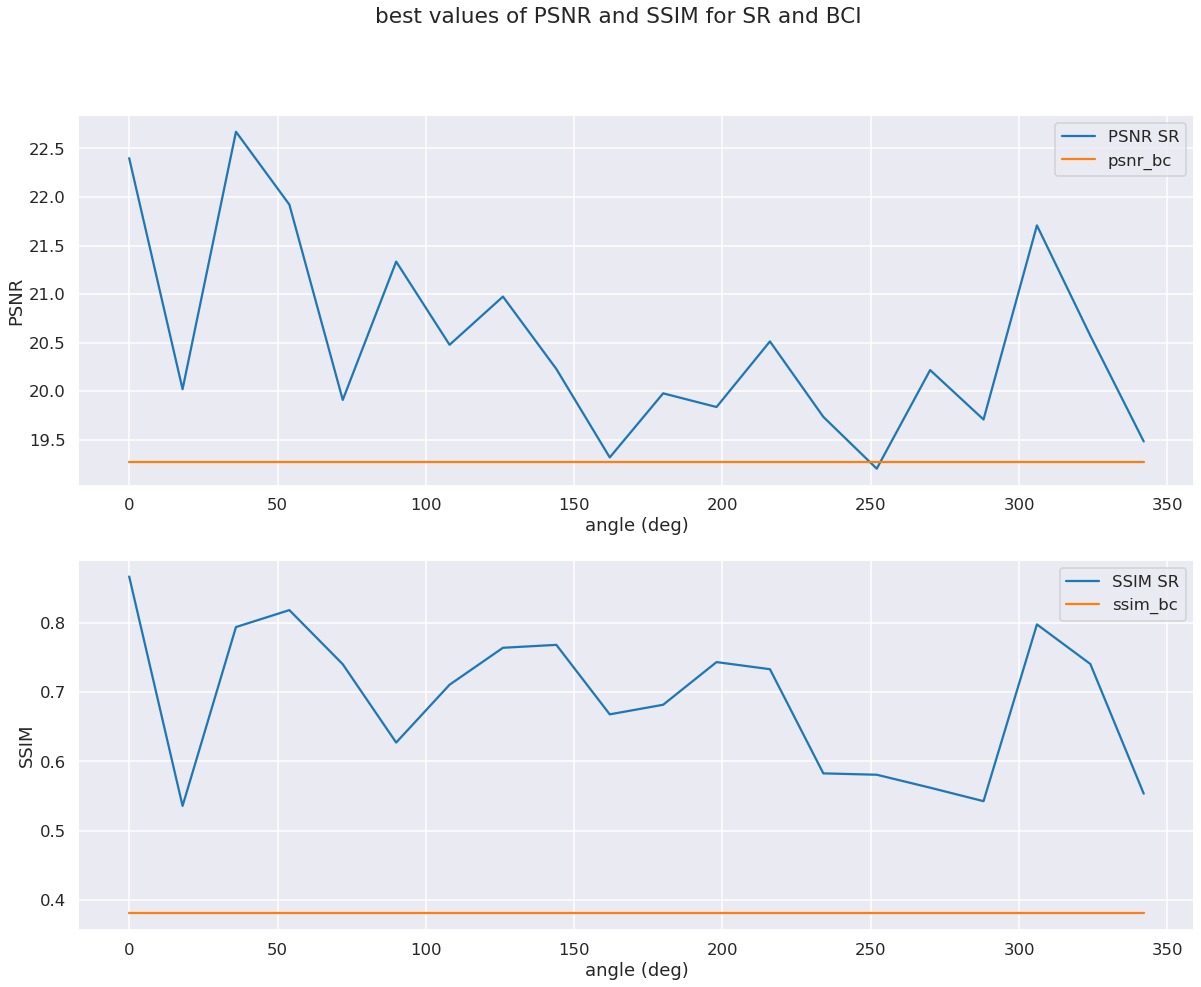

In [85]:
# same per angle

sns.set_context('talk')
sns.set_style('darkgrid')

shift_df = pd.read_csv('psnr_ssim_shift.csv')

case   = 'case01015'
weight = 't1'

angles = np.arange(0, 360, 18)
scale = 2
slide = 100

slide_mask = shift_df['slide'] == slide
scale_mask = shift_df['scale'] == scale

shift_df = shift_df[slide_mask & scale_mask]

psnr_best_values = []
ssim_best_values = []
for i in angles:
  
  angle_mask = shift_df['angle (deg)'] == i 
  
  best_psnr = shift_df[angle_mask][[f'psnr_sr_{i+1}' for i in range(3)]].values.max()
  best_ssim = shift_df[angle_mask][[f'ssim_sr_{i+1}' for i in range(3)]].values.max()

  psnr_best_values.append(best_psnr)
  ssim_best_values.append(best_ssim)
    
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,15))

ax1.plot(shift_df['angle (deg)'], psnr_best_values, label='PSNR SR')
ax2.plot(shift_df['angle (deg)'], ssim_best_values, label='SSIM SR') 
  
shift_df.plot(ax=ax1, y='psnr_bc', x='angle (deg)')
shift_df.plot(ax=ax2, y='ssim_bc', x='angle (deg)')

ax1.set_ylabel('PSNR')
ax1.legend()
ax2.legend()
ax2.set_ylabel('SSIM')

fig.suptitle('best values of PSNR and SSIM for SR and BCI')

# plt.tight_layout()
plt.show();

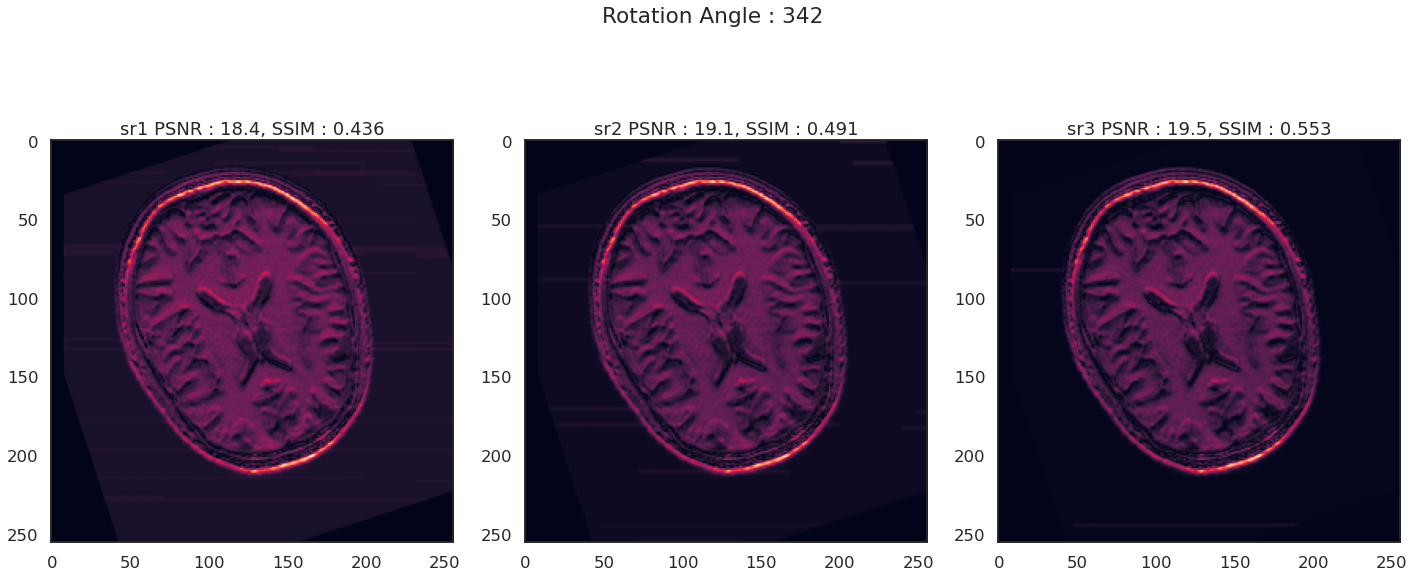

In [20]:
# animation with diff orig - sr 
sns.set_style('white')
sns.set_context('talk')

shift_df = pd.read_csv('psnr_ssim_shift.csv')

case   = 'case01015'
weight = 't1'

angle  = np.arange(0, 360, 18)
slide  = 100
scale  = 2

slide_mask = shift_df['slide'] == slide
scale_mask = shift_df['scale'] == scale

df = shift_df[slide_mask & scale_mask]

fig, row = plt.subplots(1, 3, figsize=(20, 10))

def init():

  return row

def update(frame):
     
  fig.suptitle(f'Rotation Angle : {frame}')

  orig, sr, _ = load_images(case, weight, scale, slide, frame)
  
  angle_mask = df['angle (deg)'] == frame
  data = df[angle_mask] 
  
  orig = Image.from_numpy_matrix(orig.reshape(256, 256, 1)).rotate(-frame).data[:,:,0]
  sr   = Image.from_numpy_matrix(sr).rotate(-frame).data

  for i, ax in enumerate(row):
        
    shifted = shift(sr[:,:,i], ox=int(scale*4))
#     shifted = sr[:,:,i]
    diff = np.abs(orig - shifted)
    ax.imshow(diff)
    ssim = data[f'ssim_sr_{i+1}'].values[0]
    psnr = data[f'psnr_sr_{i+1}'].values[0]
    ax.set_title(f'sr{i+1} PSNR : {psnr:.3}, SSIM : {ssim:.3}')
    
  return row

anim = FuncAnimation(fig, update, frames=angle, init_func=init, interval=1000, blit=False)

plt.tight_layout()
# anim.save(f'../images/byangle_sr_x{scale}_{slide}.gif')

In [ ]:
# images in range(0-20)
sns.set_style('darkgray')
plt.set_cmap('gray')

for i in range(25):
  
  orig, sr, bc = load_images()




In [48]:
# animation with diff orig - bc
# mostrare una immagine nel range 0-10
# mostrare immagini nel range 20-150

Text(0.5, 1.0, 'Super Resolution')

<Figure size 432x288 with 0 Axes>

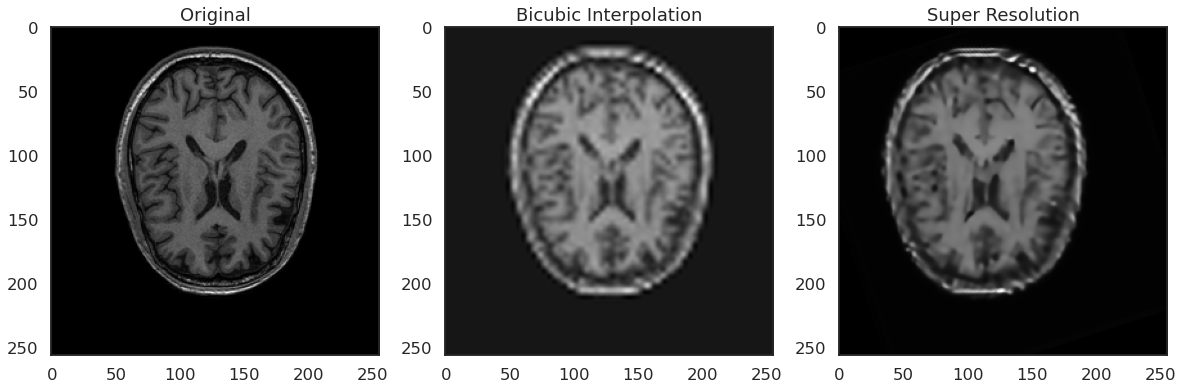

In [84]:
sns.set_context('talk')

sns.set_style('white')
plt.set_cmap('gray')

case   = 'case01015'
weight = 't1'

angle  = 18
slide  = 100
scale  = 4

orig, sr, bc = load_images(case, weight, scale, slide, angle)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

ax1.imshow(orig);
ax1.set_title('Original')
ax2.imshow(bc);
ax2.set_title('Bicubic Interpolation')

ax3.imshow(sr[:,:,0])
ax3.set_title('Super Resolution')


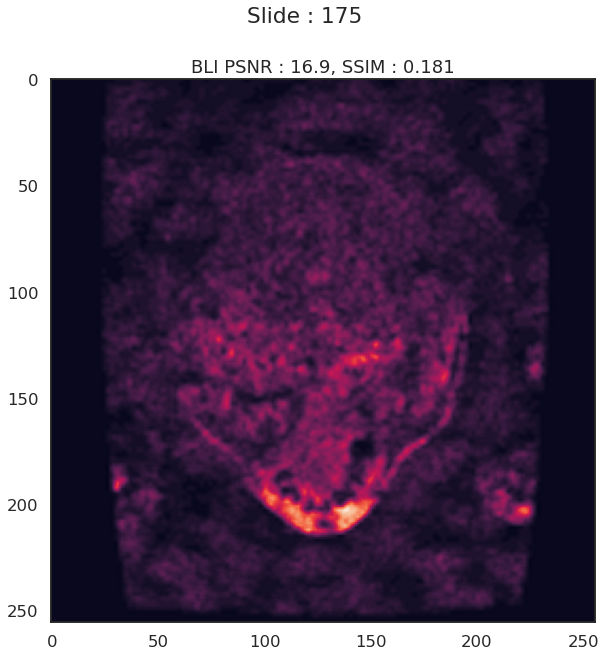

In [16]:
# animation with diff orig - bc 

sns.set_style('white')
sns.set_context('talk')

shift_df = pd.read_csv('psnr_ssim_shift.csv')

case   = 'case01015'
weight = 't1'

angle  = 0
slides = np.arange(0, 176, 1)
scale  = 2

angle_mask = shift_df['angle (deg)'] == angle
scale_mask = shift_df['scale'] == scale

df = shift_df[angle_mask & scale_mask]

fig, ax = plt.subplots(1, 1, figsize=(20, 10))

def init():
  
  return ax

def update(frame):
     
  fig.suptitle(f'Slide : {frame}')
  
  ax.clear()
  
  orig, _, bc = load_images(case, weight, scale, frame, angle)
    
  slide_mask = df['slide'] == frame
  data = df[slide_mask] 
  
  diff = np.abs(orig - bc)
  x = ax.imshow(diff)
  ssim = data[f'ssim_bc'].values[0]
  psnr = data[f'psnr_bc'].values[0]
  ax.set_title(f'BLI PSNR : {psnr:.3}, SSIM : {ssim:.3}')
      
  return ax

anim = FuncAnimation(fig, update, frames=slides, init_func=init, interval=100, blit=False)

# plt.tight_layout()
anim.save('../images/byslide_bc.gif')

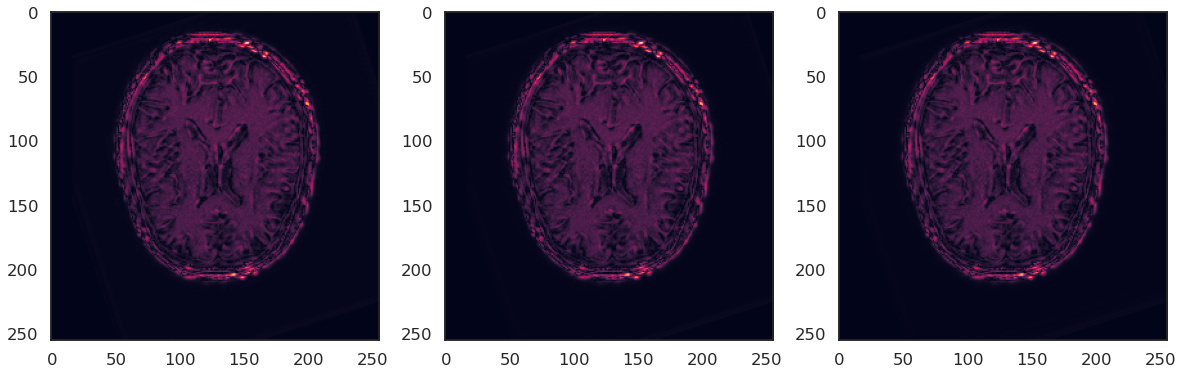

In [9]:
# visualization of angle per x4

sns.set_style('white')
sns.set_context('talk')

shift_df = pd.read_csv('psnr_ssim_shift.csv')

case   = 'case01015'
weight = 't1'

angle = 18
slide = 100
scale = 4

orig, sr, bc = load_images(case, weight, scale, slide, angle)

fig, row = plt.subplots(1, 3, figsize=(20, 10))

for i, ax in enumerate(row):
  
  shifted = shift(sr[:,:,i], ox=scale*4)
  diff = np.abs(orig - shifted)
  ax.imshow(diff)

plt.show();

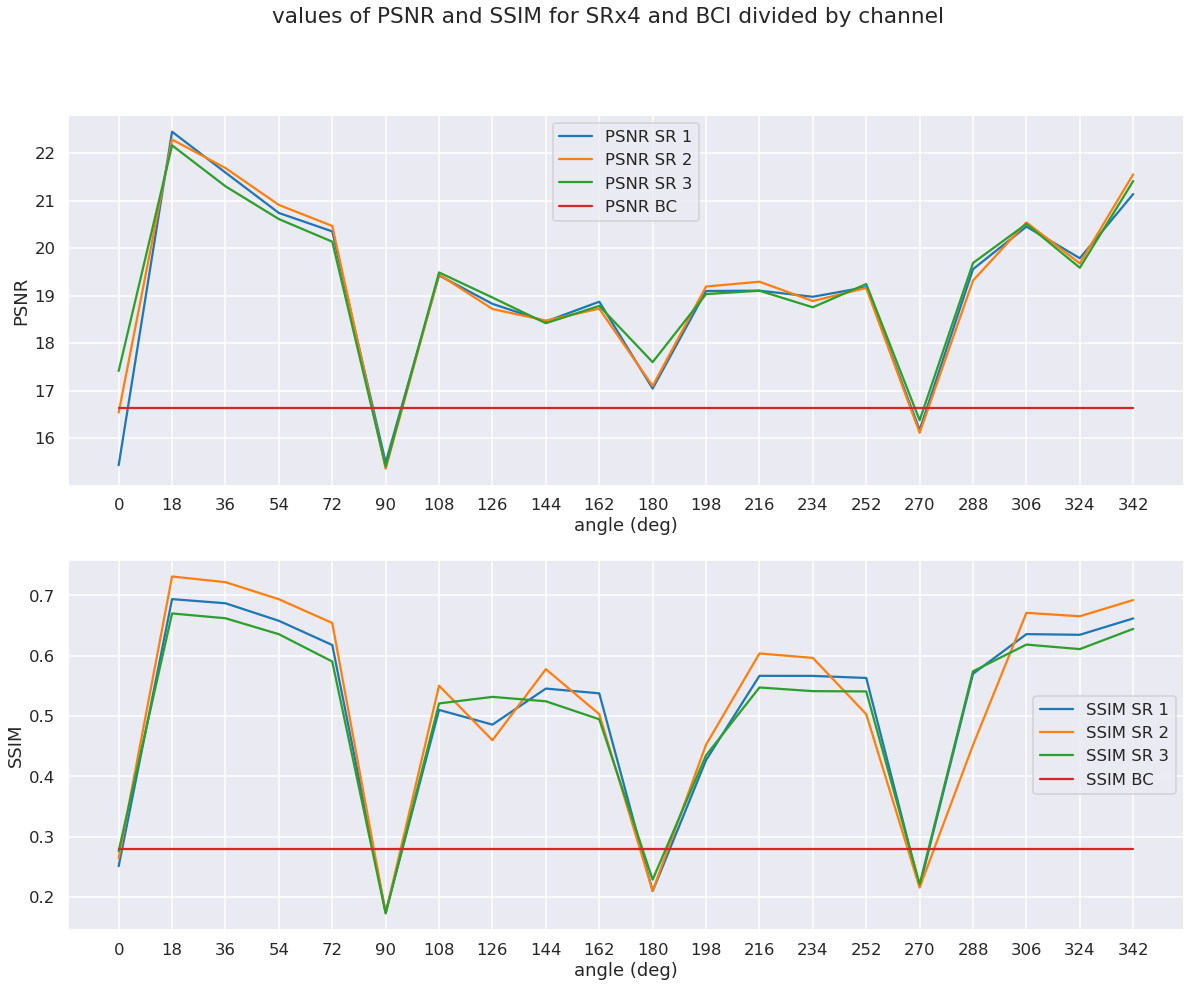

In [93]:
# visualization per angle

sns.set_style('darkgrid')
sns.set_context('talk')

shift_df = pd.read_csv('psnr_ssim_shift.csv')

case   = 'case01015'
weight = 't1'

angles = np.arange(0, 360, 18)
slide = 108
scale = 4

x_tick = np.arange(0, 360, 18)

slide_mask = shift_df['slide'] == slide
scale_mask = shift_df['scale'] == scale

shift_df = shift_df[slide_mask & scale_mask]
    
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,15))

for i in range(3):
  ax1.plot(shift_df['angle (deg)'], shift_df[f'psnr_sr_{i+1}'], label=f'PSNR SR {i+1}')
  ax2.plot(shift_df['angle (deg)'], shift_df[f'ssim_sr_{i+1}'], label=f'SSIM SR {i+1}') 
  
shift_df.plot(ax=ax1, y='psnr_bc', x='angle (deg)', label='PSNR BC')
shift_df.plot(ax=ax2, y='ssim_bc', x='angle (deg)', label='SSIM BC')

ax1.set_ylabel('PSNR')
ax1.set_xticks(x_tick)
ax1.legend()
ax2.legend()
ax2.set_ylabel('SSIM')
ax2.set_xticks(x_tick)

fig.suptitle(f'values of PSNR and SSIM for SRx{scale} and BCI divided by channel')

# plt.tight_layout()
# plt.show();
plt.savefig(f'./PSNR-SSIM_x{scale}_{slide}_byangle')

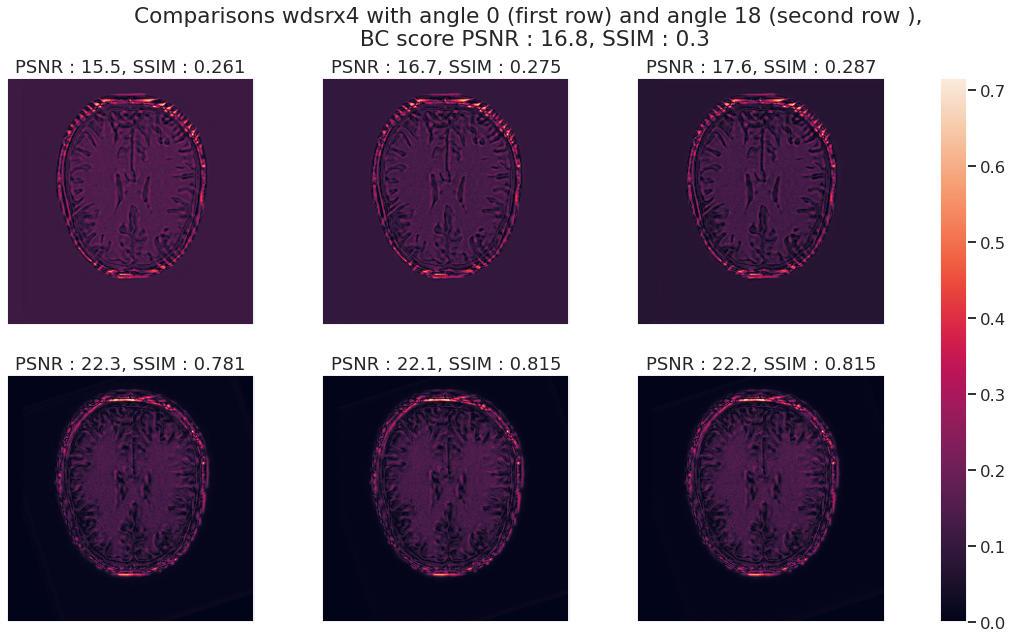

In [205]:
# confronto diff di wdsr x4 per angolo = 0 e angle 18

shift_df = pd.read_csv('psnr_ssim_shift.csv')

case = 'case01015'
weight = 't1'

scale = 4

angle1 = 0
angle2 = 18
slide  = 108

orig, sr1, _ = load_images(case, weight, scale, slide, angle1)
orig, sr2, bc = load_images(case, weight, scale, slide, angle2)

fig, (row1, row2) = plt.subplots(2, 3, figsize=(20,10))

psnr = PSNR(orig, bc)
ssim = SSIM(orig, bc)

fig.suptitle(f'Comparisons wdsrx4 with angle {angle1} (first row) and angle {angle2} (second row ), \n BC score PSNR : {psnr:.3}, SSIM : {ssim:.3}')

for i, ax in enumerate(row1):
  shifted = shift(sr1[:,:, i], ox=scale*4)
  diff = np.abs(orig - shifted)
  psnr = PSNR(orig, shifted)
  ssim = SSIM(orig, shifted)
  ax.set_title(f'PSNR : {psnr:.3}, SSIM : {ssim:.3}')
  ax.imshow(diff)
  ax.set_xticks([])
  ax.set_yticks([])
  
for i, ax in enumerate(row2):
  shifted = shift(sr2[:,:, i], ox=scale*4)
  diff = np.abs(orig - shifted)
  psnr = PSNR(orig, shifted)
  ssim = SSIM(orig, shifted)
  ax.set_title(f'PSNR : {psnr:.3}, SSIM : {ssim:.3}')
  im = ax.imshow(diff)
  ax.set_xticks([])
  ax.set_yticks([])

fig.colorbar(im, ax=row1.ravel().tolist() + row2.ravel().tolist())

plt.savefig(f'../images/wdsrx4_diff_{slide:03}_{angle1:03}_{angle2:03}')

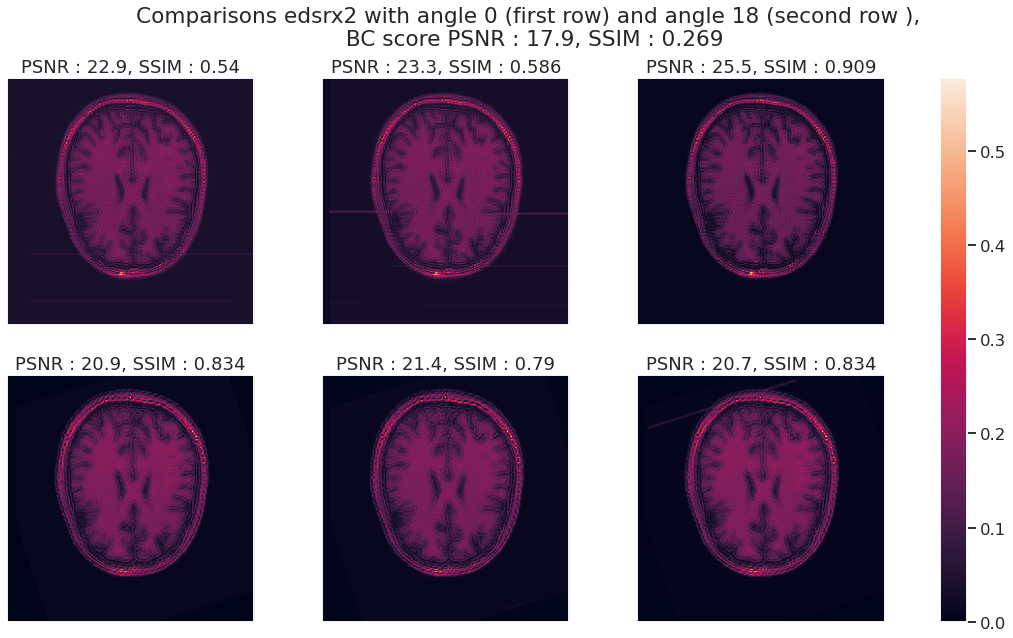

In [74]:
# diff orig - edsr for slide 108 different angle 

shift_df = pd.read_csv('psnr_ssim_shift.csv')

case = 'case01015'
weight = 't1'

scale = 2

angle1 = 0
angle2 = 18
slide  = 108

orig, sr1, _ = load_images(case, weight, scale, slide, angle1)

orig, sr2, _ = load_images(case, weight, scale, slide, angle2)

fig, (row1, row2) = plt.subplots(2, 3, figsize=(20,10))

psnr = PSNR(orig, bc)
ssim = SSIM(orig, bc)

fig.suptitle(f'Comparisons edsrx2 with angle {angle1} (first row) and angle {angle2} (second row ), \n BC score PSNR : {psnr:.3}, SSIM : {ssim:.3}')

for i, ax in enumerate(row1):
  shifted = shift(sr1[:,:, i], ox=scale*4)
  diff = np.abs(orig - shifted)
  psnr = PSNR(orig, shifted)
  ssim = SSIM(orig, shifted)
  ax.set_title(f'PSNR : {psnr:.3}, SSIM : {ssim:.3}')
  ax.imshow(diff)
  ax.set_xticks([])
  ax.set_yticks([])

for i, ax in enumerate(row2):
  shifted = shift(sr2[:,:, i], ox=scale*4)
  diff = np.abs(orig - shifted)
  psnr = PSNR(orig, shifted)
  ssim = SSIM(orig, shifted)
  ax.set_title(f'PSNR : {psnr:.3}, SSIM : {ssim:.3}')
  im = ax.imshow(diff)
  ax.set_xticks([])
  ax.set_yticks([])
  
fig.colorbar(im, ax=row1.ravel().tolist() + row2.ravel().tolist())

plt.savefig(f'../images/edsrx2_diff_{slide:03}_{angle1:03}_{angle2:03}')

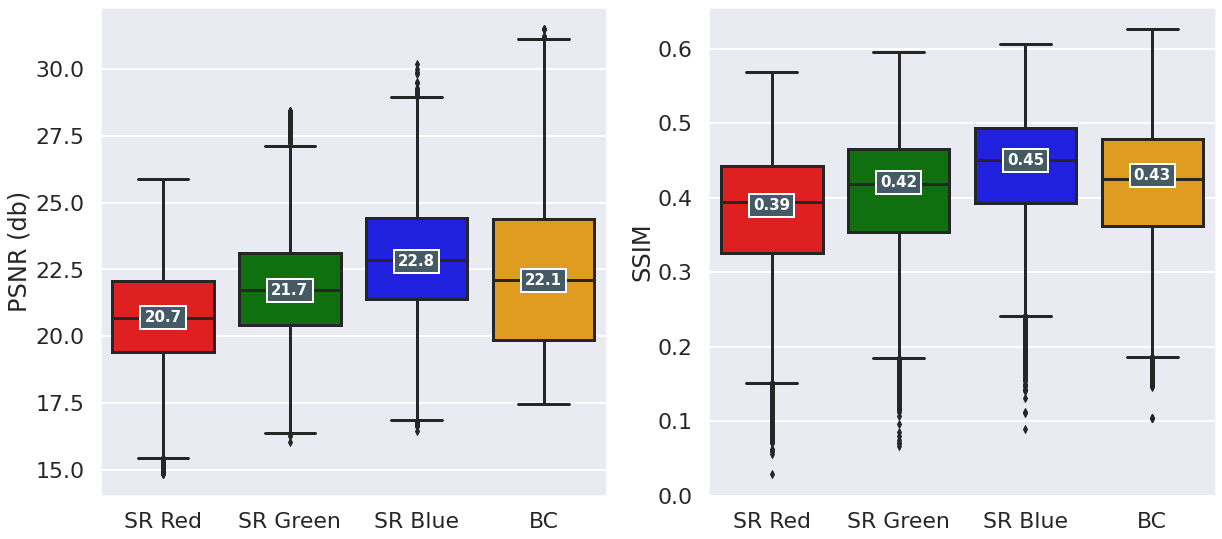

In [60]:
# Test for dataset final

sns.set_style('darkgrid')
sns.set_context('poster')

scale = 2
angle = 0

df_name = os.path.join(os.path.expanduser('~'), 'psnr_ssim_final.csv')

df = pd.read_csv(df_name)

scale_mask = df['scale'] == scale
angle_mask = df['angle (deg)'] == angle

# masked = df[scale_mask & angle_mask]
masked = df[scale_mask]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,9))

my_pal = ['red', 'green', 'blue', 'orange']
xlabel = ['SR Red', 'SR Green', 'SR Blue', 'BC'] 

bplot1 = sns.boxplot(ax=ax1,
            data=masked[['psnr_sr_1', 'psnr_sr_2', 'psnr_sr_3', 'psnr_bc']],
            palette=my_pal).set(xticklabels=xlabel)

bplot2 = sns.boxplot(ax=ax2,
            data=masked[['ssim_sr_1', 'ssim_sr_2', 'ssim_sr_3', 'ssim_bc']],
            palette=my_pal).set(xticklabels=xlabel)

lines      = ax1.get_lines(), ax2.get_lines()
categories = zip(ax1.get_xticks(), ax2.get_xticks())

for cat1, cat2 in categories:
  y1 = round(lines[0][4+cat1*6].get_ydata()[0],1) 
  y2 = round(lines[1][4+cat2*6].get_ydata()[0],2) 

  ax1.text(cat1, y1, f'{y1}', ha='center', va='center', fontweight='bold',
           size=15,color='white',bbox=dict(facecolor='#445A64'))
  
  ax2.text(cat2, y2, f'{y2}', ha='center', va='center', fontweight='bold',
         size=15,color='white',bbox=dict(facecolor='#445A64'))

ax1.set_ylabel('PSNR (db)');
ax2.set_ylabel('SSIM');

<AxesSubplot:>

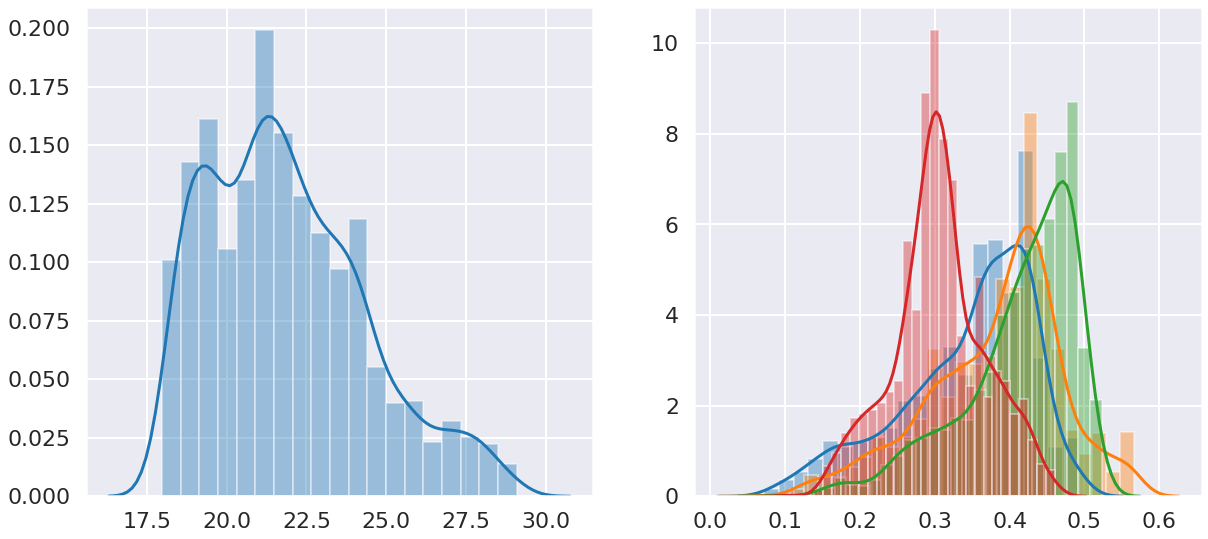

In [59]:
# histograms as above

sns.set_style('darkgrid')
sns.set_context('poster')

scale = 2

df_name = os.path.join(os.path.expanduser('~'), 'psnr_ssim_final.csv')

df = pd.read_csv(df_name)

scale_mask = df['scale'] == scale
# angle_mask = df['angle (deg)'] == angle

masked = df[scale_mask & angle_mask]
# masked = df[scale_mask]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,9))

# sns.distplot(masked[['psnr_sr_1']], ax=ax1)
# sns.distplot(masked[['psnr_sr_2']], ax=ax1)
# sns.distplot(masked[['psnr_sr_3']], ax=ax1)
sns.distplot(masked[['psnr_bc']], ax=ax1)

sns.distplot(masked[['ssim_sr_1']], ax=ax2)
sns.distplot(masked[['ssim_sr_2']], ax=ax2)
sns.distplot(masked[['ssim_sr_3']], ax=ax2)
sns.distplot(masked[['ssim_bc']],   ax=ax2)

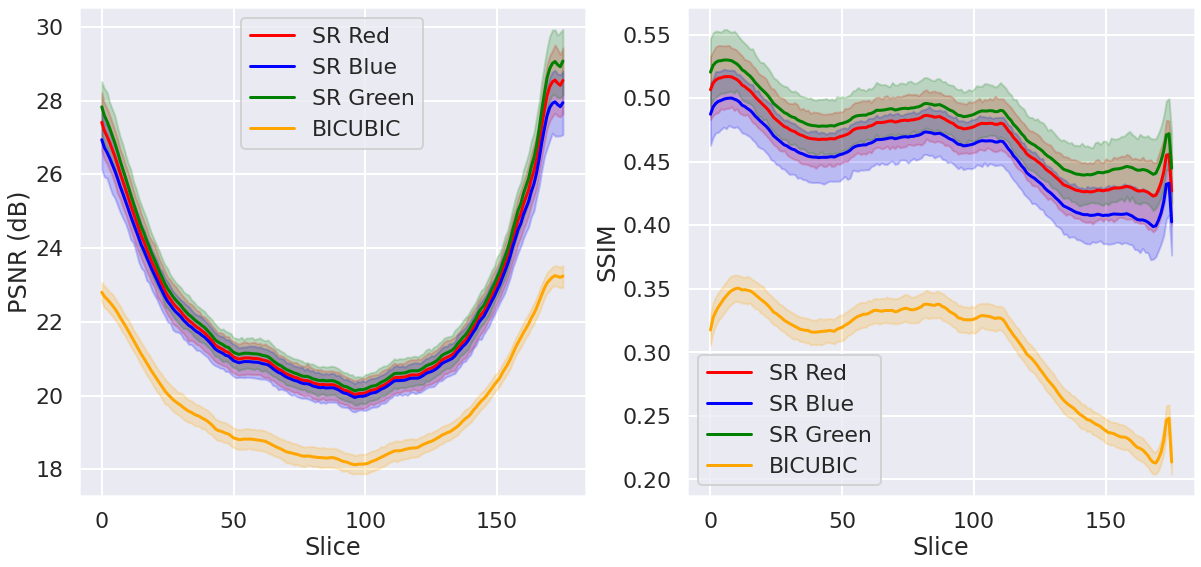

In [6]:
# distribution of psnr or ssim per slide 

sns.set_style('darkgrid')
sns.set_context('poster')

scale = 4

df_name = os.path.join(os.path.expanduser('~'), 'psnr_ssim_final.csv')

df = pd.read_csv(df_name)

scale_mask = df['scale']       == scale
# angle_mask = df['angle (deg)'] == angle

# masked = df[scale_mask & angle_mask]
masked = df[scale_mask]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,9))

ci=95

sns.lineplot(ax=ax1, data=masked, x='slide', y='psnr_sr_1', color='red', ci=ci);
sns.lineplot(ax=ax1, data=masked, x='slide', y='psnr_sr_2', color='blue', ci=ci);
sns.lineplot(ax=ax1, data=masked, x='slide', y='psnr_sr_3', color='green', ci=ci);
sns.lineplot(ax=ax1, data=masked, x='slide', y='psnr_bc',   color='orange', ci=ci);

sns.lineplot(ax=ax2, data=masked, x='slide', y='ssim_sr_1', color='red', ci=ci);
sns.lineplot(ax=ax2, data=masked, x='slide', y='ssim_sr_2', color='blue', ci=ci);
sns.lineplot(ax=ax2, data=masked, x='slide', y='ssim_sr_3', color='green', ci=ci);
sns.lineplot(ax=ax2, data=masked, x='slide', y='ssim_bc',   color='orange', ci=ci);


# add vertical lines and corresponding ticks
# ax1.axvline(23,  ls='--', color='gray', linewidth=2)
# ax1.axvline(154, ls='--', color='gray', linewidth=2)

# ax2.axvline(150, ls='--', color='gray', linewidth=2)
# ax2.axvline(13,  ls='--', color='gray', linewidth=2)

# ax1.set_xticks([0, 23, 50, 100, 154])
# ax2.set_xticks([0, 13, 50, 100, 150])

ax1.legend(labels=['SR Red', 'SR Blue', 'SR Green', 'BICUBIC']);
ax1.set_ylabel('PSNR (dB)');
ax1.set_xlabel('Slice')

ax2.legend(labels=['SR Red', 'SR Blue', 'SR Green', 'BICUBIC']);
ax2.set_ylabel('SSIM');
ax2.set_xlabel('Slice')

plt.savefig('../images/wdsr_score_slide', bbox_inches='tight', pad_inches=0)

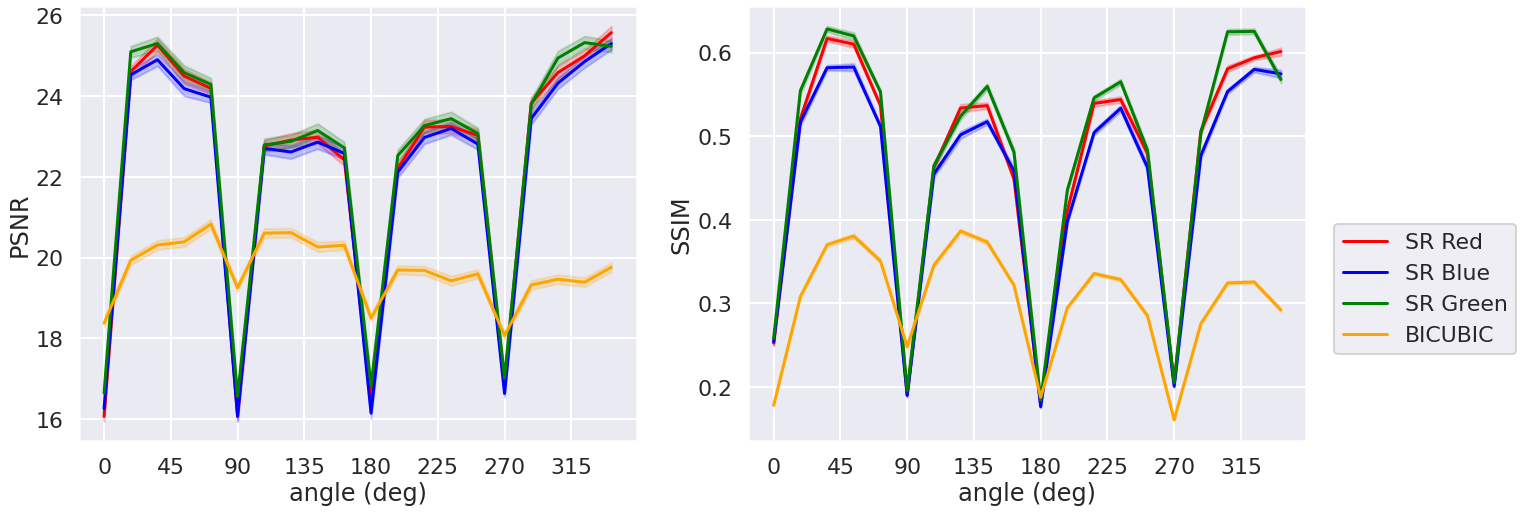

In [126]:
sns.set_style('darkgrid')
sns.set_context('poster')

scale = 4

df_name = os.path.join(os.path.expanduser('~'), 'psnr_ssim_final.csv')

df = pd.read_csv(df_name)

scale_mask = df['scale'] == scale

masked = df[scale_mask]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22,8))

sns.lineplot(ax=ax1, data=masked, x='angle (deg)', y='psnr_sr_1', color='red');
sns.lineplot(ax=ax1, data=masked, x='angle (deg)', y='psnr_sr_2', color='blue');
sns.lineplot(ax=ax1, data=masked, x='angle (deg)', y='psnr_sr_3', color='green');
sns.lineplot(ax=ax1, data=masked, x='angle (deg)', y='psnr_bc',   color='orange');

sns.lineplot(ax=ax2, data=masked, x='angle (deg)', y='ssim_sr_1', color='red');
sns.lineplot(ax=ax2, data=masked, x='angle (deg)', y='ssim_sr_2', color='blue');
sns.lineplot(ax=ax2, data=masked, x='angle (deg)', y='ssim_sr_3', color='green');
sns.lineplot(ax=ax2, data=masked, x='angle (deg)', y='ssim_bc',   color='orange');

# ax1.legend(labels=['SR Red', 'SR Blue', 'SR Green', 'BICUBIC']);
ax1.set_ylabel('PSNR');
ax1.set_xticks(range(0, 360, 36));

ax2.legend(labels=['SR Red', 'SR Blue', 'SR Green', 'BICUBIC'],
           bbox_to_anchor=(1.05, .5), loc=2, borderaxespad=0.);
ax2.set_ylabel('SSIM');
ax1.set_xticks(range(0, 360, 45));

# ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.savefig('../images/wdsr-angles', bbox_inches='tight', pad_inches=0)

ax2.set_xticks(range(0, 360, 45));

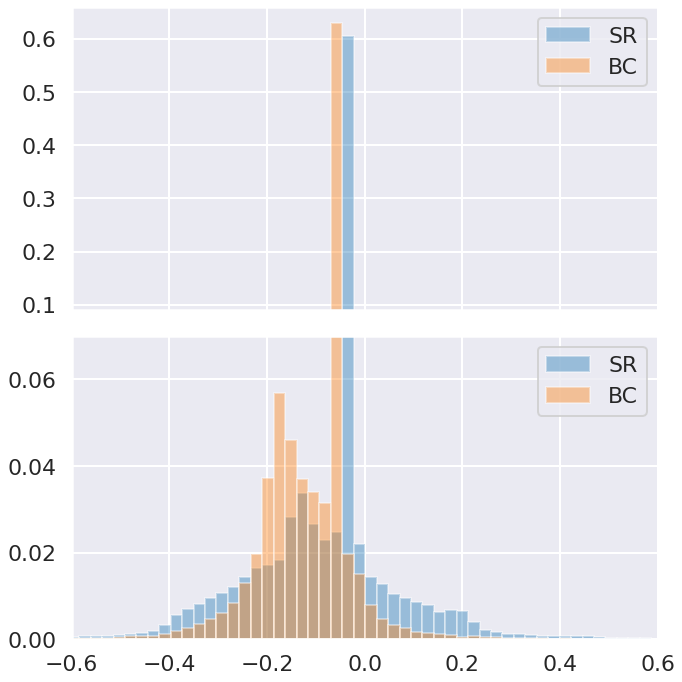

In [6]:
# diff distributions for one case
sns.set_style('darkgrid')
sns.set_context('poster')

case = 'case01015'
weight = 't1'
scale = 2
angle = 0
slide = 100
channel = 2

orig, sr, bc = load_images(case, weight, scale, angle, channel)

sr, bc = to_orientation(sr[slide], bc[slide], angle, 0)

diff_sr = orig[slide] - sr
diff_bc = orig[slide] - bc

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10), sharex=True)

weight = {'weights' : np.ones_like(diff_sr.ravel()) / (256*256) }

bins=np.linspace(min(np.concatenate([diff_sr.ravel(), diff_bc.ravel()])), 
                 max(np.concatenate([diff_sr.ravel(), diff_bc.ravel()])),
                  num=70)

sns.distplot(diff_sr.ravel(), ax=ax2, kde=False, norm_hist=False, label='SR', hist_kws=weight, bins=bins)
sns.distplot(diff_bc.ravel(), ax=ax2, kde=False, norm_hist=False, label='BC', hist_kws=weight, bins=bins)

sns.distplot(diff_sr.ravel(), ax=ax1, kde=False, norm_hist=False, label='SR', hist_kws=weight, bins=bins)
sns.distplot(diff_bc.ravel(), ax=ax1, kde=False, norm_hist=False, label='BC', hist_kws=weight, bins=bins)

ax1.set_ylim(.09,)
ax2.set_ylim(0,.07) 

ax1.set_xlim(-.6, .6) 
# ax2.set_yticks([0.02, 0.06,])

# ax1.set_title(f'Distributions of pixel-wise differences between original image, \n' + 
#               f'SR and BC results for x{scale} model at {angle}° rotation')

ax1.legend();
ax2.legend();
plt.tight_layout()

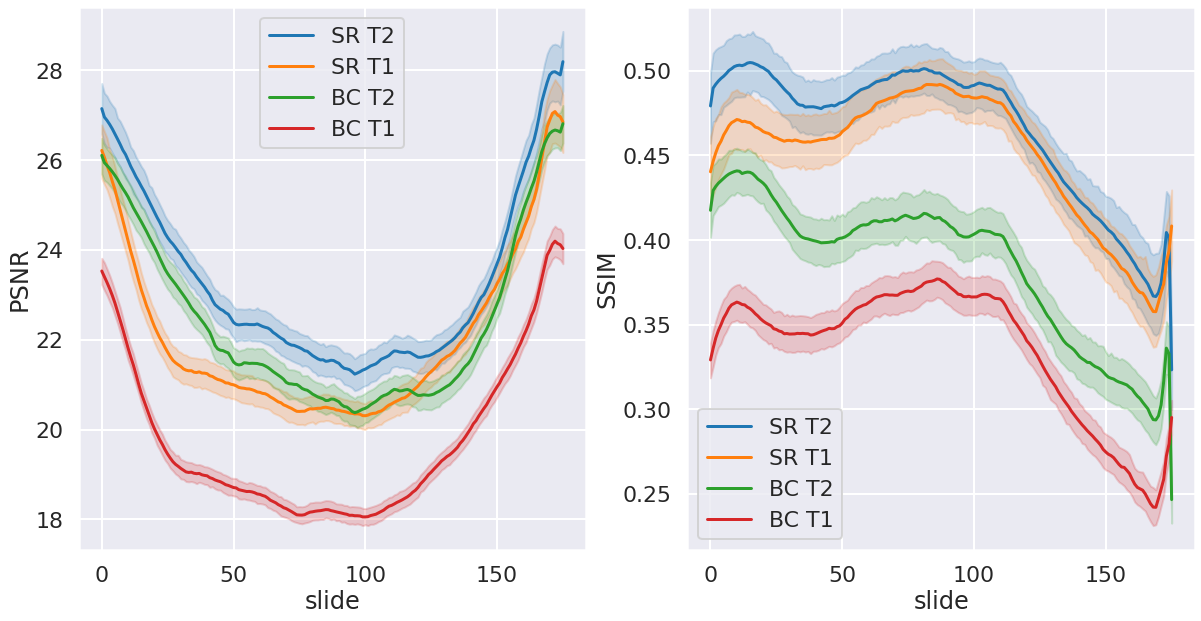

In [63]:
sns.set_style('darkgrid')
sns.set_context('poster')

w1      = 't1'
w2      = 't2'
scale   = 2
channel = 3

df_name = os.path.join(os.path.expanduser('~'), 'psnr_ssim_final.csv')

df = pd.read_csv(df_name)

w1_mask    = df['weight'] == w1
w2_mask    = df['weight'] == w2
scale_mask = df['scale']  == scale

# df1 = df[w1_mask & scale_mask]
# df2 = df[w2_mask & scale_mask]

df1 = df[w1_mask] 
df2 = df[w2_mask]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

sns.lineplot(ax=ax1, data=df2, x='slide', y=f'psnr_sr_{channel}', label='SR T2', legend='full');
sns.lineplot(ax=ax1, data=df1, x='slide', y=f'psnr_sr_{channel}', label='SR T1', legend='full');
sns.lineplot(ax=ax1, data=df2, x='slide', y=f'psnr_bc',           label='BC T2', legend='full');
sns.lineplot(ax=ax1, data=df1, x='slide', y=f'psnr_bc',           label='BC T1', legend='full');

sns.lineplot(ax=ax2, data=df2, x='slide', y=f'ssim_sr_{channel}', label='SR T2', legend='full');
sns.lineplot(ax=ax2, data=df1, x='slide', y=f'ssim_sr_{channel}', label='SR T1', legend='full');
sns.lineplot(ax=ax2, data=df2, x='slide', y=f'ssim_bc',           label='BC T2', legend='full');
sns.lineplot(ax=ax2, data=df1, x='slide', y=f'ssim_bc',           label='BC T1', legend='full');

ax1.set_ylabel('PSNR')
ax2.set_ylabel('SSIM');

# ax1.annotate('BC T1', xy=[180,22])
# ax1.annotate('BC T2', xy=[180,24])
# ax1.annotate('SR T1', xy=[180,28])
# ax1.annotate('SR T2', xy=[180,30])

# ax2.annotate('BC T1', xy=[50,.26])
# ax2.annotate('BC T2', xy=[50,.35])
# ax2.annotate('SR T1', xy=[50,.43])
# ax2.annotate('SR T2', xy=[50,.52])

# ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


<Figure size 432x288 with 0 Axes>

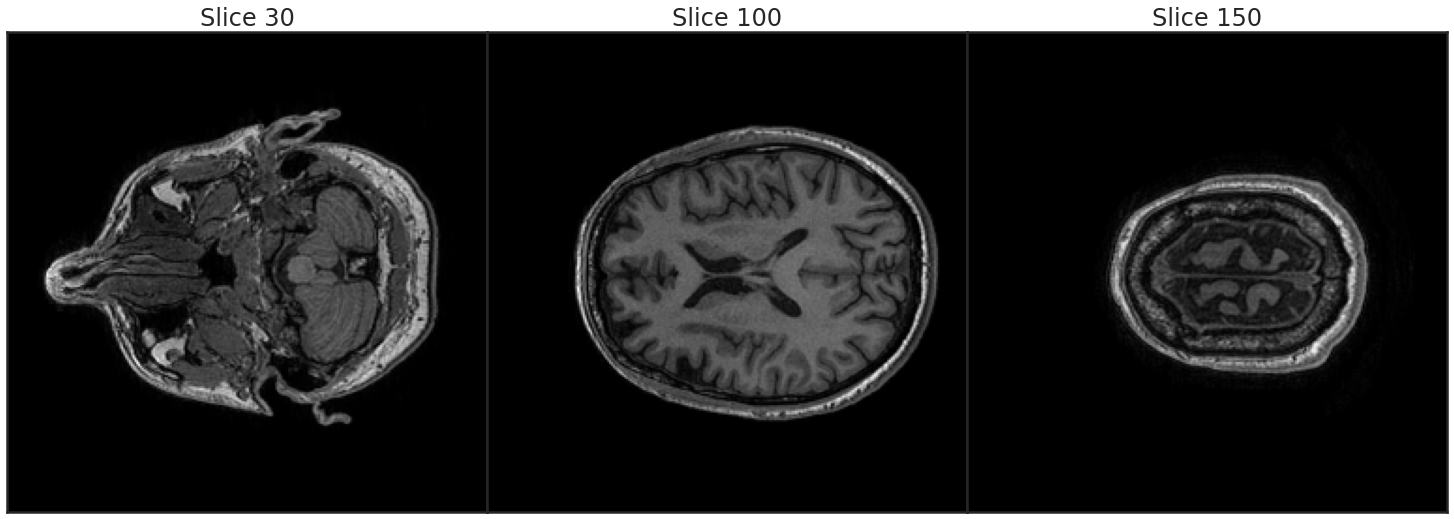

In [128]:
# HR at three stages:

sns.set_style('white')
sns.set_context('poster')
plt.set_cmap('gray')

case    = 'case01015'
weight  = 't1'
angle   = 108
channel = 2
scale   = 2

orig, _, _ = load_images(case, weight, scale, angle, channel)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))

plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)

ax1.imshow(orig[30])
ax1.set_title('Slice 30')
ax1.set_xticks([])
ax1.set_yticks([])

ax2.imshow(orig[100])
ax2.set_title('Slice 100')
ax2.set_xticks([])
ax2.set_yticks([])

ax3.imshow(orig[150])
ax3.set_title('Slice 150')
ax3.set_xticks([])
ax3.set_yticks([]);

# plt.savefig('../images/orig_slice_comp', bbox_inches='tight', pad_inches=0)
plt.show();

<Figure size 432x288 with 0 Axes>

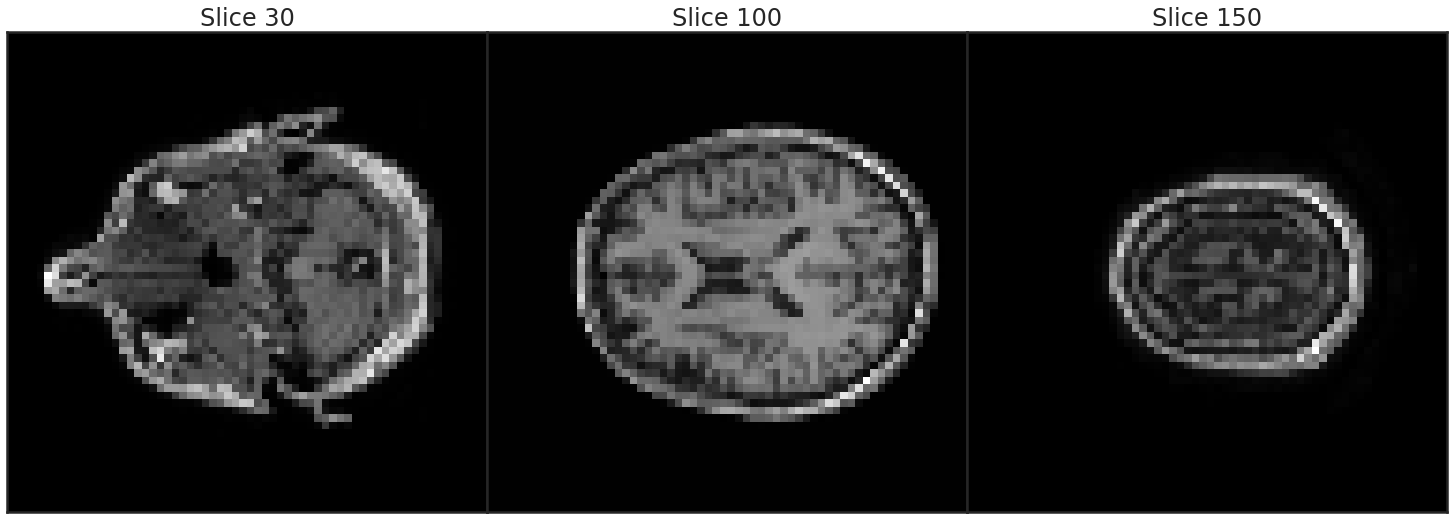

In [22]:
# starting image

sns.set_style('white')
sns.set_context('poster')
plt.set_cmap('gray')

name = os.path.join(os.path.expanduser('~'), 'data_NAMIC', 't1', 'case01015_t1_4lr_bc_gauss.nii')

img = nib.load(name).get_fdata().transpose(2, 0, 1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))

plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)

ax1.imshow(cv2.rotate(img[30], cv2.ROTATE_180))
ax1.set_title('Slice 30')
ax1.set_xticks([])
ax1.set_yticks([])

ax2.imshow(cv2.rotate(img[100], cv2.ROTATE_180))
ax2.set_title('Slice 100')
ax2.set_xticks([])
ax2.set_yticks([])

ax3.imshow(cv2.rotate(img[150], cv2.ROTATE_180))
ax3.set_title('Slice 150')
ax3.set_xticks([])
ax3.set_yticks([]);

# plt.savefig('../images/inp4_slice_comp', bbox_inches='tight', pad_inches=0)
plt.show();

<Figure size 432x288 with 0 Axes>

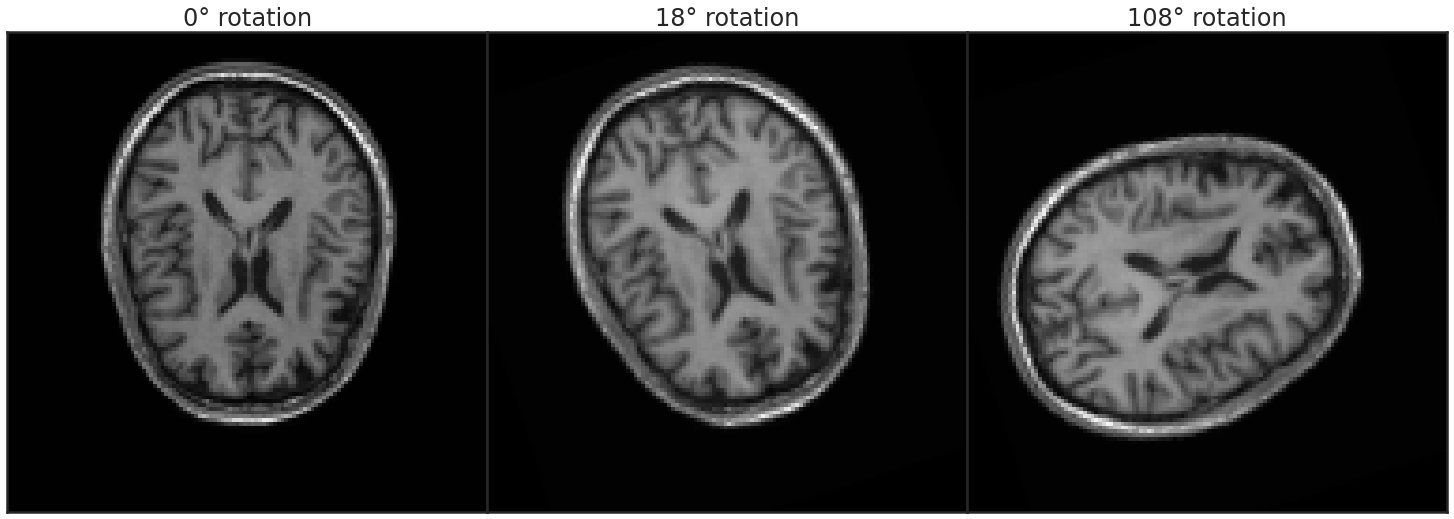

In [129]:
# input image rotations

sns.set_style('white')
sns.set_context('poster')
plt.set_cmap('gray')

name = os.path.join(os.path.expanduser('~'), 'data_NAMIC', 't1', 'case01015_t1_2lr_bc_gauss.nii')

img = nib.load(name).get_fdata().transpose(2, 0, 1)[100]

img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)

h, w = img.shape

img_rot_18 = Image.from_numpy_matrix(img.reshape(h, w, 1)).rotate(18).data[:,:,0]

img_rot_108 = Image.from_numpy_matrix(img.reshape(h, w, 1)).rotate(108).data[:,:,0]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))

plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)

ax1.imshow(img)
ax1.set_title('0° rotation')
ax1.set_xticks([])
ax1.set_yticks([])

ax2.imshow(img_rot_18)
ax2.set_title('18° rotation')
ax2.set_xticks([])
ax2.set_yticks([])

ax3.imshow(img_rot_108)
ax3.set_title('108° rotation')
ax3.set_xticks([]);
ax3.set_yticks([]);

# plt.savefig('../images/rotations', bbox_inches='tight', pad_inches=0)
plt.show();


<Figure size 432x288 with 0 Axes>

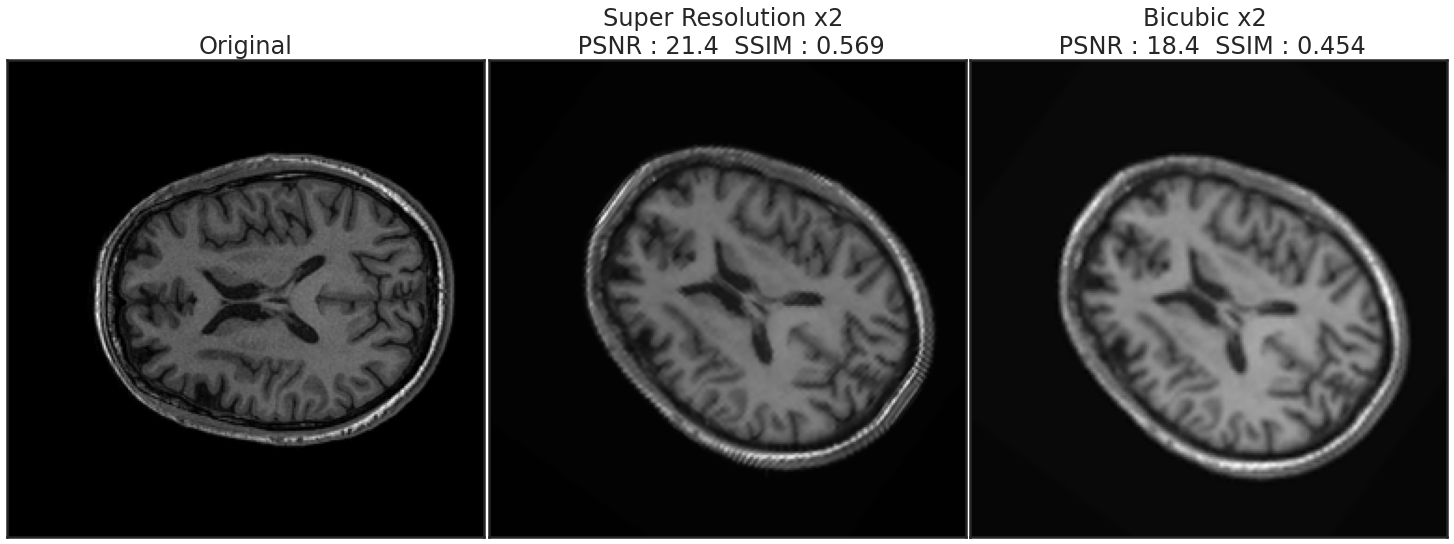

In [119]:
sns.set_style('white')
sns.set_context('poster')
plt.set_cmap('gray')

case    = 'case01015'
weigth  = 't1'
scale   = 2
angle   = 36
channel = 2
slide   = 100

df_name = os.path.join(os.path.expanduser('~'), 'psnr_ssim_final.csv')

df = pd.read_csv(df_name)

case_mask  = df['case'] == case
w_mask     = df['weight'] == weigth
scale_mask = df['scale'] == scale
ang_mask   = df['angle (deg)'] == angle
slice_mask = df['slide'] == slide

masked = df[case_mask & w_mask & scale_mask & ang_mask & slice_mask]

orig, sr, bc = load_images(case, weigth, scale, angle, channel)

slides, h, w = orig.shape

# sr = Image.from_numpy_matrix(sr[slide].reshape(h, w, 1)).rotate(-90).flip(axis=0).data[:,:,0]
# bc = Image.from_numpy_matrix(bc[slide].reshape(h, w, 1)).rotate(-90).flip(axis=0).data[:,:,0]

sr = cv2.flip(cv2.rotate(sr[slide], cv2.ROTATE_90_CLOCKWISE), flipCode=0)
bc = cv2.flip(cv2.rotate(bc[slide], cv2.ROTATE_90_CLOCKWISE), flipCode=0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))

plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0.01)
plt.margins(0,0)

ax1.imshow(orig[slide])
ax1.set_title('Original')
ax1.set_xticks([])
ax1.set_yticks([])

ax2.imshow(shift(sr, oy=0, ox=0))
ax2.set_title(f'Super Resolution x{scale} \n PSNR : {masked[f"psnr_sr_{channel+1}"].values[0]:.3}  '+ 
                                           f'SSIM : {masked[f"ssim_sr_{channel+1}"].values[0]:.3}')
ax2.set_xticks([])
ax2.set_yticks([])

ax3.imshow(bc)
ax3.set_title(f'Bicubic x{scale} \n PSNR : {masked["psnr_bc"].values[0]:.3}  '+ 
                                  f'SSIM : {masked["ssim_bc"].values[0]:.3}')
ax3.set_xticks([]);
ax3.set_yticks([]);

# plt.savefig('../images/wdsr-comp-images', bbox_inches='tight', pad_inches=0)
plt.show();
